In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerTuple
plt.rcParams['font.size'] = 16
import time
from copy import deepcopy
import pandas as pd

from xsfit.objects.containers import Univ_container
from xsfit.preprocessing.simple import simple_radius_ranges,simple_dirs,simple_x_hex_mesh
from xsfit.preprocessing.geometry import Multi_geom_3D
from xsfit.preprocessing.ETF import Univ_mesh_maker,Indicator
from xsfit.objects.models import Linear_model
from xsfit.functions.mesh import get_vec_data

from xsInterface.functions.main import Main
from xsInterface.functions.dyn3d import DYN3D
from xsInterface.functions.nodalexpansion import NodalExpansion

In [2]:
# options(repr.plot.width = 5, repr.plot.height = 5)

In [3]:
it0 = 2
it2 = 3

### Fit Settings

In [4]:
# Indicator function radius specification
spatial_dim = 3     # spatial dimension used for ETF modeling
space_ratio = 1     # radius ranges are generated with spacing 
                    # space_ratio*sqrt(wx**2+wy**2+wz**2)
n_radius_ranges = 7 # Number of radii generated

# Indicator function directional specification
# 1: isotropic ETF
# 2: radial and axial ETFs
# 3: x, y, and z ETFs
# 4: radial, -z, and +z ETFs
# 6: -x, +x, -y, +y, -z, and +z ETFs
# mode = 3

# Custom direction setting
dir_ids  = ['mz','pz']
set_dirs = {'mz':(0,0,-1),
            'pz':(0,0, 1)}
dir_group_ids  = ['mz','pz']
# set_dir_groups = {'iso':['mz','pz']}
set_dir_groups = {'mz':['mz'],
                  'pz':['pz']}

# Miscellaneous Fit Settings
norm    = False  # Whether or not to normalize indicator functions
res_cor = False  # Specifies whether to use the fit residual as a constant 
                 # correction term for fits

# Ridge Regression settings
# Ridge  = True # Ridge is enabled by default
# norm   = True # Features are be normalized in Ridge regression by default
logamin =  -2  # log of the minimum alpha value in the grid search
logamax =   2  # log of the maximum alpha value in the grid search
nalphas =   20 # Number of alphas during grid search

### Geometry Settings

In [5]:
# Assembly flat-to-flat Pitch
P = 4.9

# Number of Mesh Elements
nx = 67
ny = 48
nz = 45
mesh_shape = (ny,nx,nz)

# Size of Mesh Elements
wx = P/2
wy = np.sqrt(3)/4*P
wz = 3
mesh_spacing = (wy,wx,wz)

# Boundary Condition
bcs = ('v','v','v')

The below settings follow from the above, but they can also be tweaked by the user

In [6]:
# Extract radius ranges settings
local_id,radius_range_ids,set_radius_ranges =\
    simple_radius_ranges(spatial_dim,space_ratio,mesh_spacing,n_radius_ranges)

# Extract directional settings
# dir_ids,set_dirs,dir_group_ids,set_dir_groups = simple_dirs(spatial_dim,mode)

# Ridge Hyperparameter settings
# nalphas = logamax-logamin+1
alphas  = 10**np.linspace(logamin,logamax,nalphas)

### xsInterface Operations

In [7]:
# -----------------------------------------------------------------------------
#             NEUTRONICS   pickle files with all the results
# -----------------------------------------------------------------------------
#          percent power_ radial pp in percent _ axial shape              
roots = {}
roots[0] = r'data/P80_pp_15nonunifAx'
roots[1] = r'data/P100_pp_10nonunifAx'
roots[2] = r'data/P100_pp_10unifAx'
roots[3] = r'data/P100_pp_25nonunifAx'
roots[4] = r'data/P100_pp_25unifAx'

pckFiles = {}
pckFiles[0] = roots[0]+r'/P80_pp_15nonunifAx.pkl'
pckFiles[1] = roots[1]+r'/P100_pp_10nonunifAx.pkl'
pckFiles[2] = roots[2]+r'/P100_pp_10unifAx.pkl'
pckFiles[3] = roots[3]+r'/P100_pp_25nonunifAx.pkl'
pckFiles[4] = roots[4]+r'/P100_pp_25unifAx.pkl'

In [8]:
# Load the cross section file
with open(pckFiles[it0], 'rb') as file:
    data0 = pickle.load(file)

with open(pckFiles[it2], 'rb') as file:
    data2 = pickle.load(file)

xs0r = data0['xs']
xs2r = data2['xs']

In [9]:
def xs_to_vec(xs,param,g=0):
    vec = np.zeros(0)
    for xs_ch in xs.core.corevalues[param]:
        vec = np.hstack((vec,xs_ch[:,g]))
    return vec

In [10]:
rab0_g0 = xs_to_vec(xs0r,'infrabsxs'  ,0)
nsf0_g0 = xs_to_vec(xs0r,'infnsf'     ,0)
trp0_g0 = xs_to_vec(xs0r,'inftranspxs',0)
adf0_g0 = xs_to_vec(xs0r,'adf'        ,0)

rab0_g1 = xs_to_vec(xs0r,'infrabsxs'  ,1)
nsf0_g1 = xs_to_vec(xs0r,'infnsf'     ,1)
trp0_g1 = xs_to_vec(xs0r,'inftranspxs',1)
adf0_g1 = xs_to_vec(xs0r,'adf'        ,1)

scm0_g0 = xs_to_vec(xs0r,'infsp0'  ,0)
scm0_g1 = xs_to_vec(xs0r,'infsp0'  ,1)
scm0_g2 = xs_to_vec(xs0r,'infsp0'  ,2)
scm0_g3 = xs_to_vec(xs0r,'infsp0'  ,3)

rab2_g0 = xs_to_vec(xs2r,'infrabsxs'  ,0)
nsf2_g0 = xs_to_vec(xs2r,'infnsf'     ,0)
trp2_g0 = xs_to_vec(xs2r,'inftranspxs',0)
adf2_g0 = xs_to_vec(xs2r,'adf'        ,0)

rab2_g1 = xs_to_vec(xs2r,'infrabsxs'  ,1)
nsf2_g1 = xs_to_vec(xs2r,'infnsf'     ,1)
trp2_g1 = xs_to_vec(xs2r,'inftranspxs',1)
adf2_g1 = xs_to_vec(xs2r,'adf'        ,1)

scm2_g0 = xs_to_vec(xs2r,'infsp0'  ,0)
scm2_g1 = xs_to_vec(xs2r,'infsp0'  ,1)
scm2_g2 = xs_to_vec(xs2r,'infsp0'  ,2)
scm2_g3 = xs_to_vec(xs2r,'infsp0'  ,3)

In [11]:
# Create the universe vector
ch_ids = ['F06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'R01', 'R02', 'R03', 'R04', 'R05']
la_ids = np.linspace(1,17,17).astype(int).astype(str)
univ_vec = np.zeros(0)
for ch_id in ch_ids:
    univ_ch = np.char.add(ch_id+'_',la_ids)
    univ_vec = np.hstack((univ_vec,univ_ch))

In [12]:
# Create the fit groups
univ_grp = {}
univ_grp["refl"] = np.zeros(0)
univ_grp["fuel"] = np.zeros(0)

for univ_id in univ_vec:
    ch_id,la_id = univ_id.split('_')
    if ('R' in ch_id) or int(la_id)==1 or int(la_id)==17:
        univ_grp["refl"] = np.hstack((univ_grp["refl"],univ_id))
    else:
        univ_grp["fuel"] = np.hstack((univ_grp["fuel"],univ_id))

### TH Operations

In [13]:
# -----------------------------------------------------------------------------
#            THERMAL    npz files with all the results
# -----------------------------------------------------------------------------
npzFiles = {}
npzFiles[0] = roots[0]+r'/P80_pp_15nonunifAx.npz'
npzFiles[1] = roots[1]+r'/P100_pp_10nonunifAx.npz'
npzFiles[2] = roots[2]+r'/P100_pp_10unifAx.npz'
npzFiles[3] = roots[3]+r'/P100_pp_25nonunifAx.npz'
npzFiles[4] = roots[4]+r'/P100_pp_25unifAx.npz'

In [14]:
data0 = np.load(npzFiles[it0])
data2 = np.load(npzFiles[it2])

In [15]:
# Need to flip the thermal properties axially to match the neutronic model
Tf0 =     data0['fuelT'][:, ::-1]   # fuel Temperature in the channel
Df0 = abs(data0['fuelD'][:, ::-1])  # fuel Density in the channel
Tf2 =     data2['fuelT'][:, ::-1] 
Df2 = abs(data2['fuelD'][:, ::-1])
fl_ = np.ones_like(Tf0)
rf_ = np.zeros_like(Tf0)

In [16]:
# Insert zeros at reflector locations
def insert_refls(arr,v=np.zeros(7)):
    rfb = np.full((7,1),v[0])
    rft = np.full((7,1),v[1])
    rfr = np.tile(v[2:].reshape(-1,1),(1,17))
    arr = np.hstack((rfb,arr,rft))
    arr = np.vstack((arr,rfr))
    return arr

In [17]:
Tf0 = insert_refls(Tf0)
Df0 = insert_refls(Df0)
Tf2 = insert_refls(Tf2)
Df2 = insert_refls(Df2)
fl_ = insert_refls(fl_)
# rfa = insert_refls(rf_,np.array([1,1,0,0,0,0,0]))
rfb = insert_refls(rf_,np.array([1,0,0,0,0,0,0]))
rft = insert_refls(rf_,np.array([0,1,0,0,0,0,0]))
rfr = insert_refls(rf_,np.array([0,0,1,1,1,1,1]))
# rf1 = insert_refls(rf_,np.array([0,0,1,0,0,0,0]))
# rf2 = insert_refls(rf_,np.array([0,0,0,1,0,0,0]))
# rf3 = insert_refls(rf_,np.array([0,0,0,0,1,0,0]))
# rf4 = insert_refls(rf_,np.array([0,0,0,0,0,1,0]))
# rf5 = insert_refls(rf_,np.array([0,0,0,0,0,0,1]))

In [18]:
# Flatten to vector form
Tf0 = Tf0.flatten()
Df0 = Df0.flatten()
Tf2 = Tf2.flatten()
Df2 = Df2.flatten()
fl_ = fl_.flatten()
# rfa = rfa.flatten()
rfb = rfb.flatten()
rft = rft.flatten()
rfr = rfr.flatten()
# rf1 = rf1.flatten()
# rf2 = rf2.flatten()
# rf3 = rf3.flatten()
# rf4 = rf4.flatten()
# rf5 = rf5.flatten()

### Universe Container Demo

In [19]:
univ_ = Univ_container(univ_vec,univ_grp)

### Universe Mesh Maker Demo

In [20]:
# Axial geometry
z = np.array([0, 5, 13, 21, 29, 37, 45, 53, 61, 69, 77, 85, 93, 101, 109, 117, 125, 135])
dz = np.diff(z)
zmid = (z[1:]+z[:-1])/2
axial_geom = z

In [21]:
# Radial geometry
with open('channel_map.pickle', 'rb') as handle:
    channel_map = pickle.load(handle)
channel_vec,radial_geom = simple_x_hex_mesh((0,0),P,channel_map,void_id="VOI")

In [37]:
channel_map

array([['VOI', 'VOI', 'VOI', 'VOI', 'VOI', 'VOI', 'VOI', 'VOI', 'VOI',
        'VOI', 'VOI', 'R01', 'R01', 'R01', 'R01', 'R01', 'R01', 'R01',
        'R01', 'R01', 'R01', 'R01', 'R01'],
       ['VOI', 'VOI', 'VOI', 'VOI', 'VOI', 'VOI', 'VOI', 'VOI', 'VOI',
        'VOI', 'R01', 'R02', 'R02', 'R02', 'R02', 'R02', 'R02', 'R02',
        'R02', 'R02', 'R02', 'R02', 'R01'],
       ['VOI', 'VOI', 'VOI', 'VOI', 'VOI', 'VOI', 'VOI', 'VOI', 'VOI',
        'R01', 'R02', 'R03', 'R03', 'R03', 'R03', 'R03', 'R03', 'R03',
        'R03', 'R03', 'R03', 'R02', 'R01'],
       ['VOI', 'VOI', 'VOI', 'VOI', 'VOI', 'VOI', 'VOI', 'VOI', 'R01',
        'R02', 'R03', 'R04', 'R04', 'R04', 'R04', 'R04', 'R04', 'R04',
        'R04', 'R04', 'R03', 'R02', 'R01'],
       ['VOI', 'VOI', 'VOI', 'VOI', 'VOI', 'VOI', 'VOI', 'R01', 'R02',
        'R03', 'R04', 'R05', 'R05', 'R05', 'R05', 'R05', 'R05', 'R05',
        'R05', 'R04', 'R03', 'R02', 'R01'],
       ['VOI', 'VOI', 'VOI', 'VOI', 'VOI', 'VOI', 'R01', 'R02', 'R03',

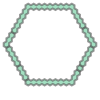

In [36]:
radial_geom.geoms[-2]

In [22]:
type(radial_geom)

shapely.geometry.collection.GeometryCollection

In [23]:
# Start timing the ETF process
start_time = time.time()

In [24]:
# Initialize the mesh maker
mesh = Univ_mesh_maker(spatial_dim)

# Set mesh parameters
x0 = -P/4
y0 = -3*np.sqrt(3)/8*P
z0 = 0.5
mesh.set_mesh(mesh_shape,mesh_spacing,(y0,x0,z0))

# Universe_mat
univ_mat = univ_vec.reshape((-1,17))
multi_geom = Multi_geom_3D(univ_mat,axial_geom,radial_geom,void_id="VOI")

# Generate the mesh
univ_mesh = mesh.generate_mesh(univ_vec,multi_geom,void_id="VOI")

mesh_time = time.time()

### Indicator Function Demo

In [25]:
### Initialization Stage ######################################################

# Initialize the Indicator_model
ind = Indicator(3)

# Cartesian Mesh Settings
ind.set_mesh(mesh_shape, mesh_spacing, bcs)

# Indicator id settings
ind.set_ids(radius_range_ids, local_id, dir_ids, dir_group_ids)

### Parameter Specification Stage #############################################

# Use Indicator radii
ind.set_radius_ranges(**set_radius_ranges)

# Set directions
ind.set_dirs(**set_dirs)

# Set direction groups
ind.set_dir_groups(**set_dir_groups)

### Get indicator meshes ######################################################

_ = ind.get_ind_meshes(norm)

ind_time = time.time()

### ETF Model Demo

In [26]:
### Initialization Stage ######################################################

# Initialize the linear model - specifying an indicator model automatically 
# Enables ETF methods
model = Linear_model(univ_)

# Enable ETF functionality
model.set_ETF(ind,mesh)

# Remaining settings
model.set_ids(state_ids=["0","2"], dep_ids=["rab_g0","nsf_g0","trp_g0","adf_g0","rab_g1","nsf_g1","trp_g1","adf_g1",
                                            "scm_g0","scm_g1","scm_g2","scm_g3"], 
              inp_ids=["Tf","Df","fl","rfb","rft","rfr"])

### Parameter Specification Stage #############################################

# For fitting
model.set_inp_vecs("0", Tf=np.sqrt(Tf0), Df=Df0, fl=fl_, rfb=rfb, rft=rft,
                   rfr=rfr) # High input #


# For prediction
model.set_inp_vecs("2", Tf=np.sqrt(Tf2), Df=Df2, fl=fl_, rfb=rfb, rft=rft,
                   rfr=rfr) # High input #

# Set dependent variables
model.set_dep_vecs("0", rab_g0=rab0_g0, nsf_g0=nsf0_g0, trp_g0=trp0_g0, adf_g0=adf0_g0,
                        rab_g1=rab0_g1, nsf_g1=nsf0_g1, trp_g1=trp0_g1, adf_g1=adf0_g1,
                        scm_g0=scm0_g0, scm_g1=scm0_g1, scm_g2=scm0_g2, scm_g3=scm0_g3)

# True perturbed states are specififed here for comparison of results
model.set_dep_vecs("2", rab_g0=rab2_g0, nsf_g0=nsf2_g0, trp_g0=trp2_g0, adf_g0=adf2_g0,
                        rab_g1=rab2_g1, nsf_g1=nsf2_g1, trp_g1=trp2_g1, adf_g1=adf2_g1,
                        scm_g0=scm2_g0, scm_g1=scm2_g1, scm_g2=scm2_g2, scm_g3=scm2_g3)

### Regression Stage ##########################################################

# Perform the fit
model.fit(fit_states=["0"], alphas=alphas, corr_mode=None, 
          copy_arrs=["refl"], copy_mode="0")

fit_time = time.time()

# Perform the prediction
model.predict()

pre_time = time.time()

In [27]:
alphas = {}
for key,value in model.fit_results['fuel'].items():
    if 'adf' in key:
        continue
    alphas[key] = value[1].alpha_

In [28]:
alphas

{'rab_g0': 1.2742749857031335,
 'nsf_g0': 0.18329807108324356,
 'trp_g0': 2.06913808111479,
 'rab_g1': 0.29763514416313175,
 'nsf_g1': 0.29763514416313175,
 'trp_g1': 1.2742749857031335,
 'scm_g0': 0.18329807108324356,
 'scm_g1': 0.4832930238571752,
 'scm_g2': 0.4832930238571752,
 'scm_g3': 0.7847599703514611}

In [29]:
print("mesh time: {}".format(mesh_time - start_time))

mesh time: 0.2134861946105957


In [30]:
print("ind time: {}".format( ind_time -  mesh_time))

ind time: 0.6275646686553955


In [31]:
print("fit time: {}".format( fit_time -   ind_time))

fit time: 105.86017322540283


In [32]:
print("pre time: {}".format( pre_time -   fit_time))

pre time: 0.04355645179748535


### Plot Results

In [33]:
np.linspace(0,7,8)[:7]

array([0., 1., 2., 3., 4., 5., 6.])

In [34]:
mask0 = np.isin(univ_vec,univ_mat[ 0,:])
mask1 = np.isin(univ_vec,univ_mat[ 1,:])
mask2 = np.isin(univ_vec,univ_mat[ 2,:])
mask3 = np.isin(univ_vec,univ_mat[ 3,:])
mask4 = np.isin(univ_vec,univ_mat[ 4,:])
mask5 = np.isin(univ_vec,univ_mat[ 5,:])
mask6 = np.isin(univ_vec,univ_mat[ 6,:])
maskf = np.isin(univ_vec,univ_mat[:7,1:-1])
masks = [mask6,mask3,mask0]

In [35]:
params = ("dep_"    ,"pre_"     ,"dep_"      )
states = ("0"       ,"2"        ,"2"         )
FOM_mat = np.zeros((3,3,2))
for i,mask in enumerate(masks):
    for j,prop in enumerate(["rab","nsf","trp"]):
        for g in [0,1]:
            ids = ("{}_g{}".format(prop,g),)*4
            xs_data = get_vec_data(model,params,states,ids)
            num = np.linalg.norm(xs_data[2][mask][1:-1]-xs_data[0][mask][1:-1]) 
            den = np.linalg.norm(xs_data[2][mask][1:-1]-xs_data[1][mask][1:-1]) 
            FOM_mat[i,j,g] = num/den
FOM_mat = np.round(FOM_mat,2)

In [36]:
FOM_mat[:,:,0]

array([[ 1.17,  5.72,  2.76],
       [ 1.18,  6.94,  3.47],
       [ 1.37, 10.6 ,  2.49]])

In [37]:
FOM_mat[:,:,1]

array([[5.7 , 5.67, 2.95],
       [7.61, 7.59, 3.77],
       [5.95, 5.96, 3.45]])

In [38]:
params = ("dep_"    ,"dep_"      )
states = ("0"       ,"2"         )
MAPE0_mat = np.zeros([3,2])
for j,prop in enumerate(["nsf","rab","trp"]):
    for g in [0,1]:
        ids = ("{}_g{}".format(prop,g),)*4
        xs_data = get_vec_data(model,params,states,ids)
        MAPE0_mat[j,g] = 100*np.max(abs(1-xs_data[0][maskf]/xs_data[1][maskf]))
MAPE0_mat = np.round(MAPE0_mat,2)

In [39]:
MAPE0_mat

array([[5.47, 5.88],
       [1.88, 4.6 ],
       [1.32, 1.03]])

In [40]:
params = ("pre_"    ,"dep_"      )
states = ("2"       ,"2"         )
MAPE1_mat = np.zeros([3,2])
for j,prop in enumerate(["nsf","rab","trp"]):
    for g in [0,1]:
        ids = ("{}_g{}".format(prop,g),)*4
        xs_data = get_vec_data(model,params,states,ids)
        MAPE1_mat[j,g] = 100*np.max(abs(1-xs_data[0][maskf]/xs_data[1][maskf]))
MAPE1_mat = np.round(MAPE1_mat,2)

In [41]:
MAPE1_mat

array([[1.21, 1.04],
       [1.55, 0.81],
       [0.57, 0.34]])

In [42]:
params = ("dep_"    ,"dep_"      )
states = ("0"       ,"2"         )
MAPE0_mat = np.zeros([1,4])
for j,prop in enumerate(["scm"]):
    for g in [0,1,2,3]:
        ids = ("{}_g{}".format(prop,g),)*4
        xs_data = get_vec_data(model,params,states,ids)
        MAPE0_mat[j,g] = 100*np.max(abs(1-xs_data[0][maskf]/xs_data[1][maskf]))
MAPE0_mat = np.round(MAPE0_mat,2)

In [43]:
MAPE0_mat

array([[ 0.72,  1.06, 11.78,  0.63]])

In [44]:
params = ("pre_"    ,"dep_"      )
states = ("2"       ,"2"         )
MAPE1_mat = np.zeros([1,4])
for j,prop in enumerate(["scm"]):
    for g in [0,1,2,3]:
        ids = ("{}_g{}".format(prop,g),)*4
        xs_data = get_vec_data(model,params,states,ids)
        MAPE1_mat[j,g] = 100*np.max(abs(1-xs_data[0][maskf]/xs_data[1][maskf]))
MAPE1_mat = np.round(MAPE1_mat,2)

In [45]:
MAPE1_mat

array([[0.19, 0.8 , 5.75, 0.31]])

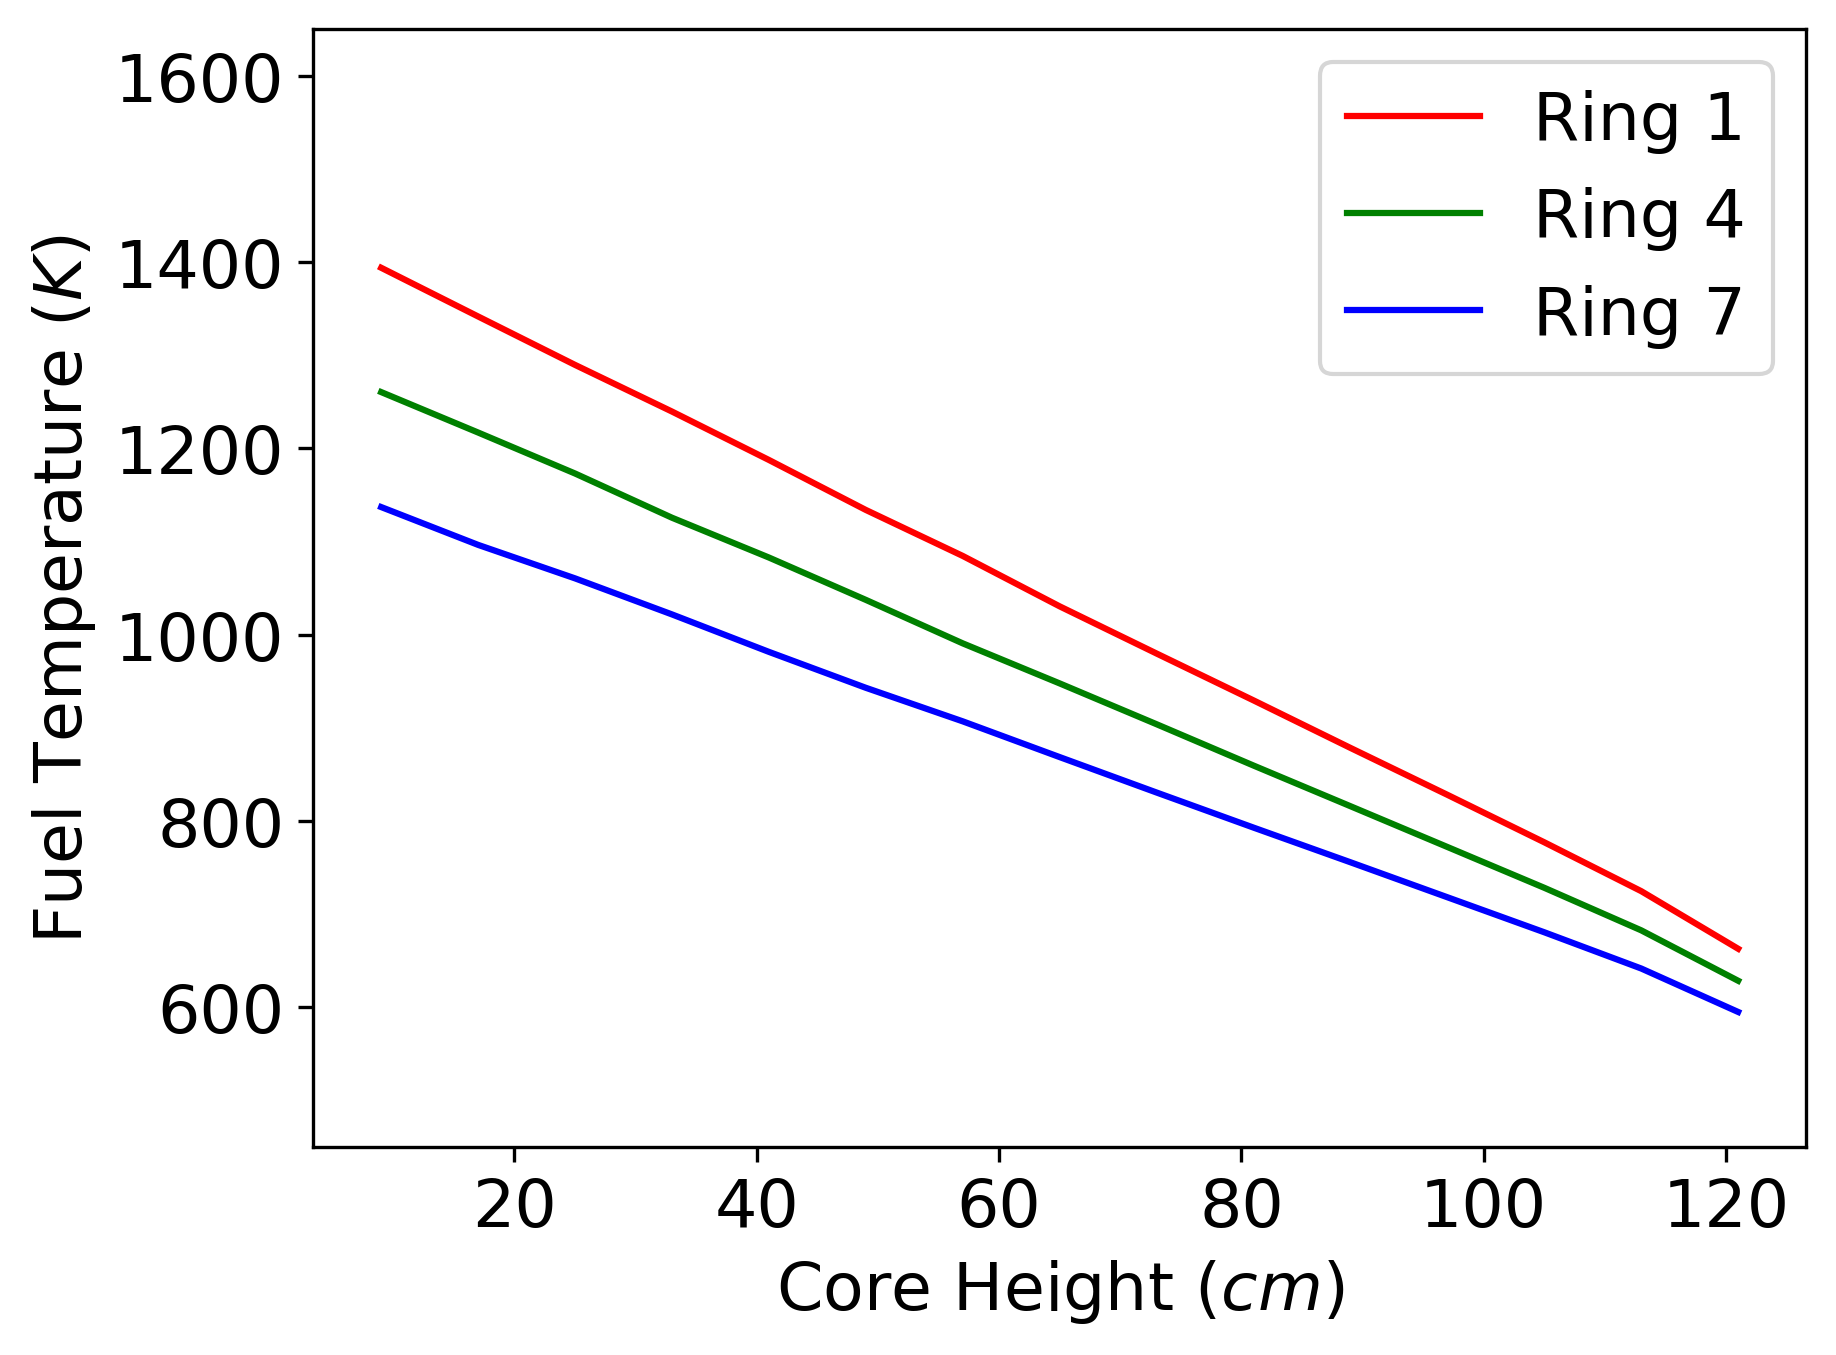

In [46]:
params = ("inp_", "inp_", "inp_")
states = ("0"   , "0"   , "0"   )
ids    = ("Tf"  , "Tf"  , "Tf"  )

Tf_data = get_vec_data(model,params,states,ids)
labels = ("Ring 1", "Ring 4", "Ring 7")

plt.figure()
plt.plot(zmid[1:-1],Tf_data[0][mask6][1:-1]**2,"r-")
plt.plot(zmid[1:-1],Tf_data[1][mask3][1:-1]**2,"g-")
plt.plot(zmid[1:-1],Tf_data[2][mask0][1:-1]**2,"b-")
plt.legend(labels)
plt.ylim([450,1650])
plt.ylabel("Fuel Temperature ($K$)")
plt.xlabel("Core Height ($cm$)")
plt.tight_layout()
plt.savefig(r"D:\OneDrive - Georgia Institute of Technology\Desktop\ETF_Journal\NTP_results\Tf_state0.png")
plt.show()

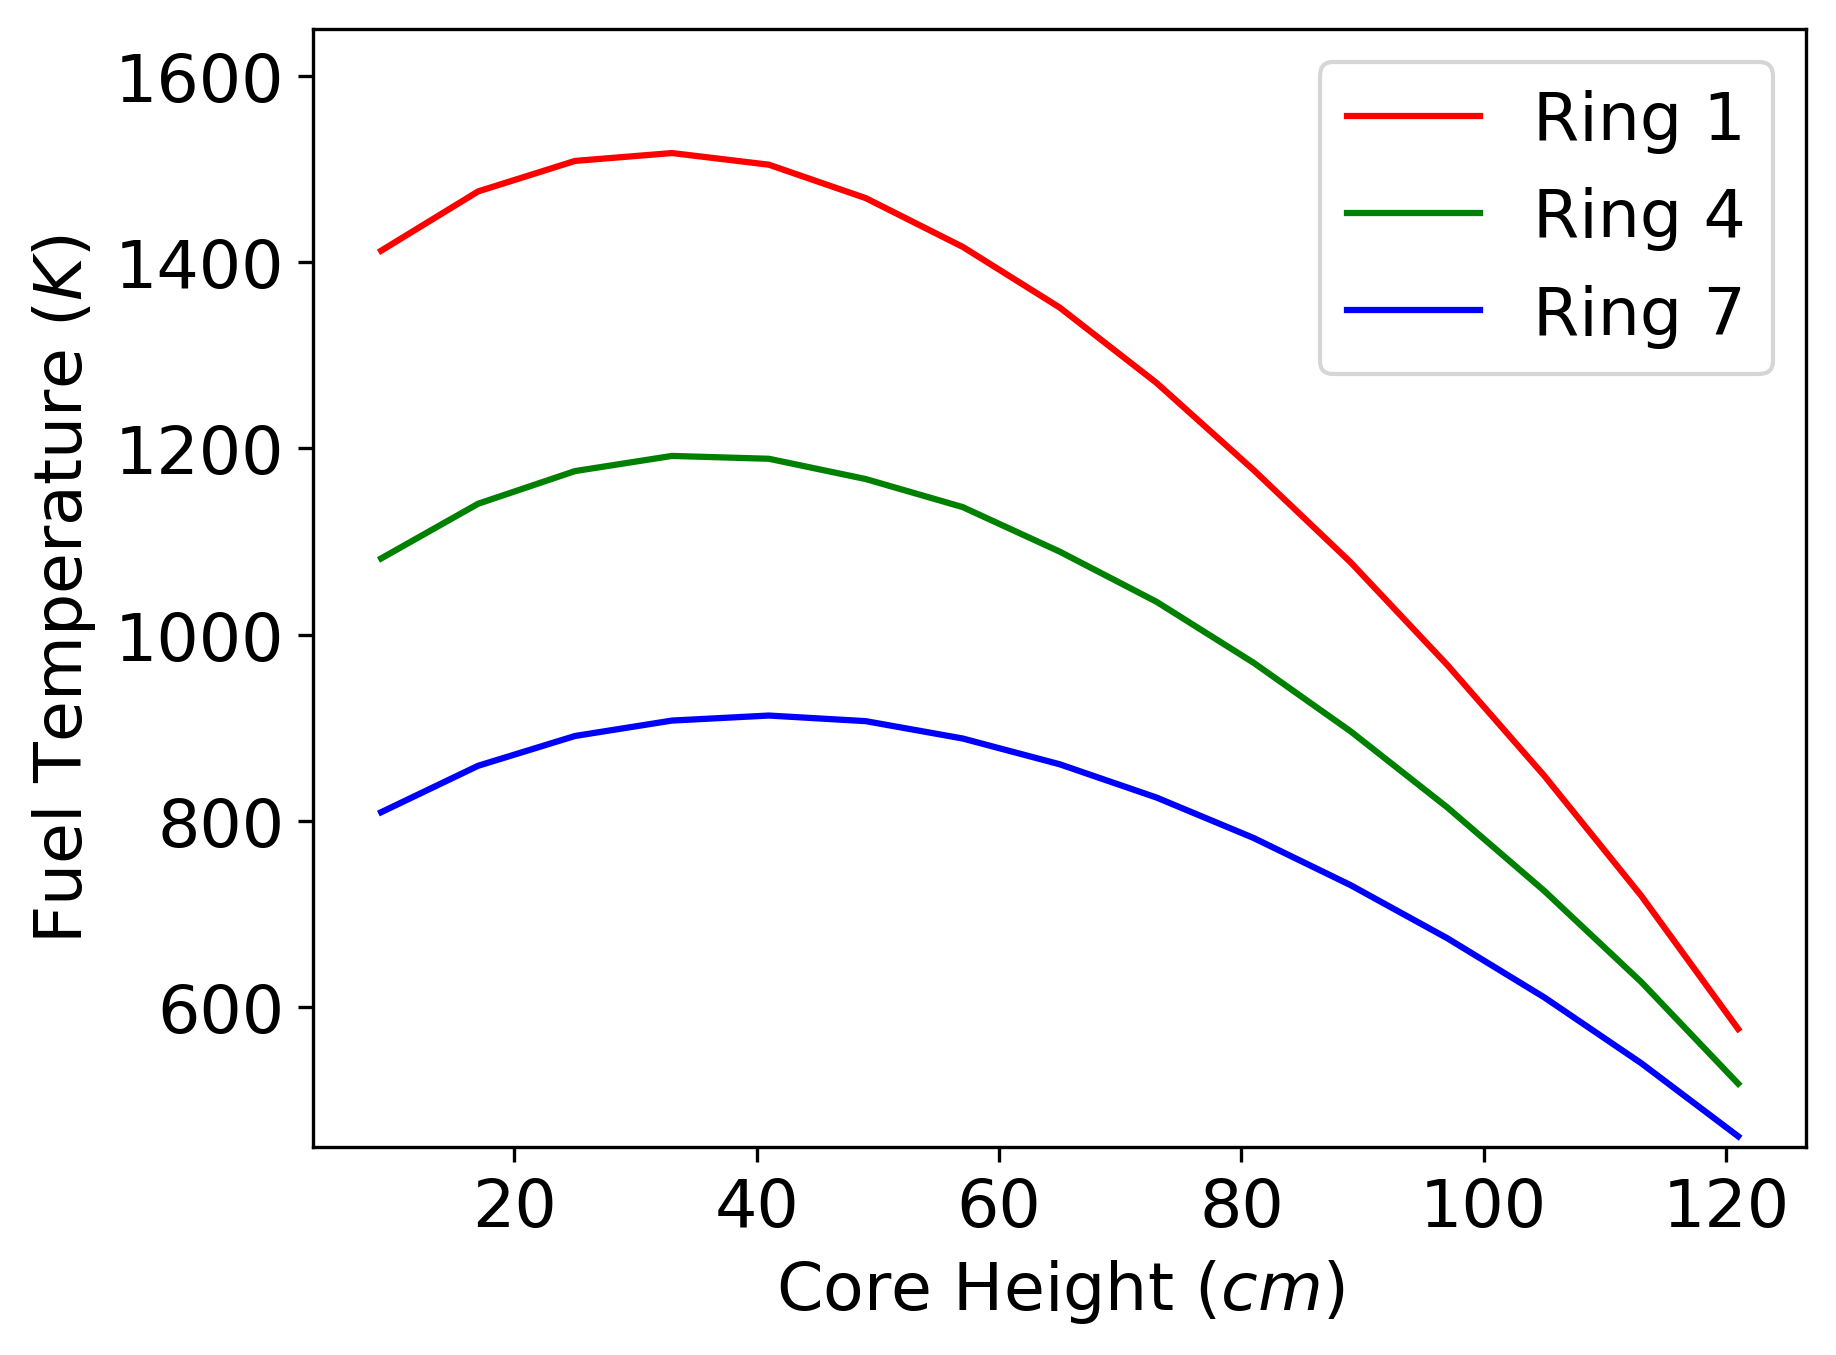

In [47]:
params = ("inp_", "inp_", "inp_")
states = ("2"   , "2"   , "2"   )
ids    = ("Tf"  , "Tf"  , "Tf"  )

Tf_data = get_vec_data(model,params,states,ids)
labels = ("Ring 1", "Ring 4", "Ring 7")

plt.figure()
plt.plot(zmid[1:-1],Tf_data[0][mask6][1:-1]**2,"r-")
plt.plot(zmid[1:-1],Tf_data[1][mask3][1:-1]**2,"g-")
plt.plot(zmid[1:-1],Tf_data[2][mask0][1:-1]**2,"b-")
plt.legend(labels)
plt.ylim([450,1650])
plt.ylabel("Fuel Temperature ($K$)")
plt.xlabel("Core Height ($cm$)")
plt.tight_layout()
plt.savefig(r"D:\OneDrive - Georgia Institute of Technology\Desktop\ETF_Journal\NTP_results\Tf_state1.png")
plt.show()

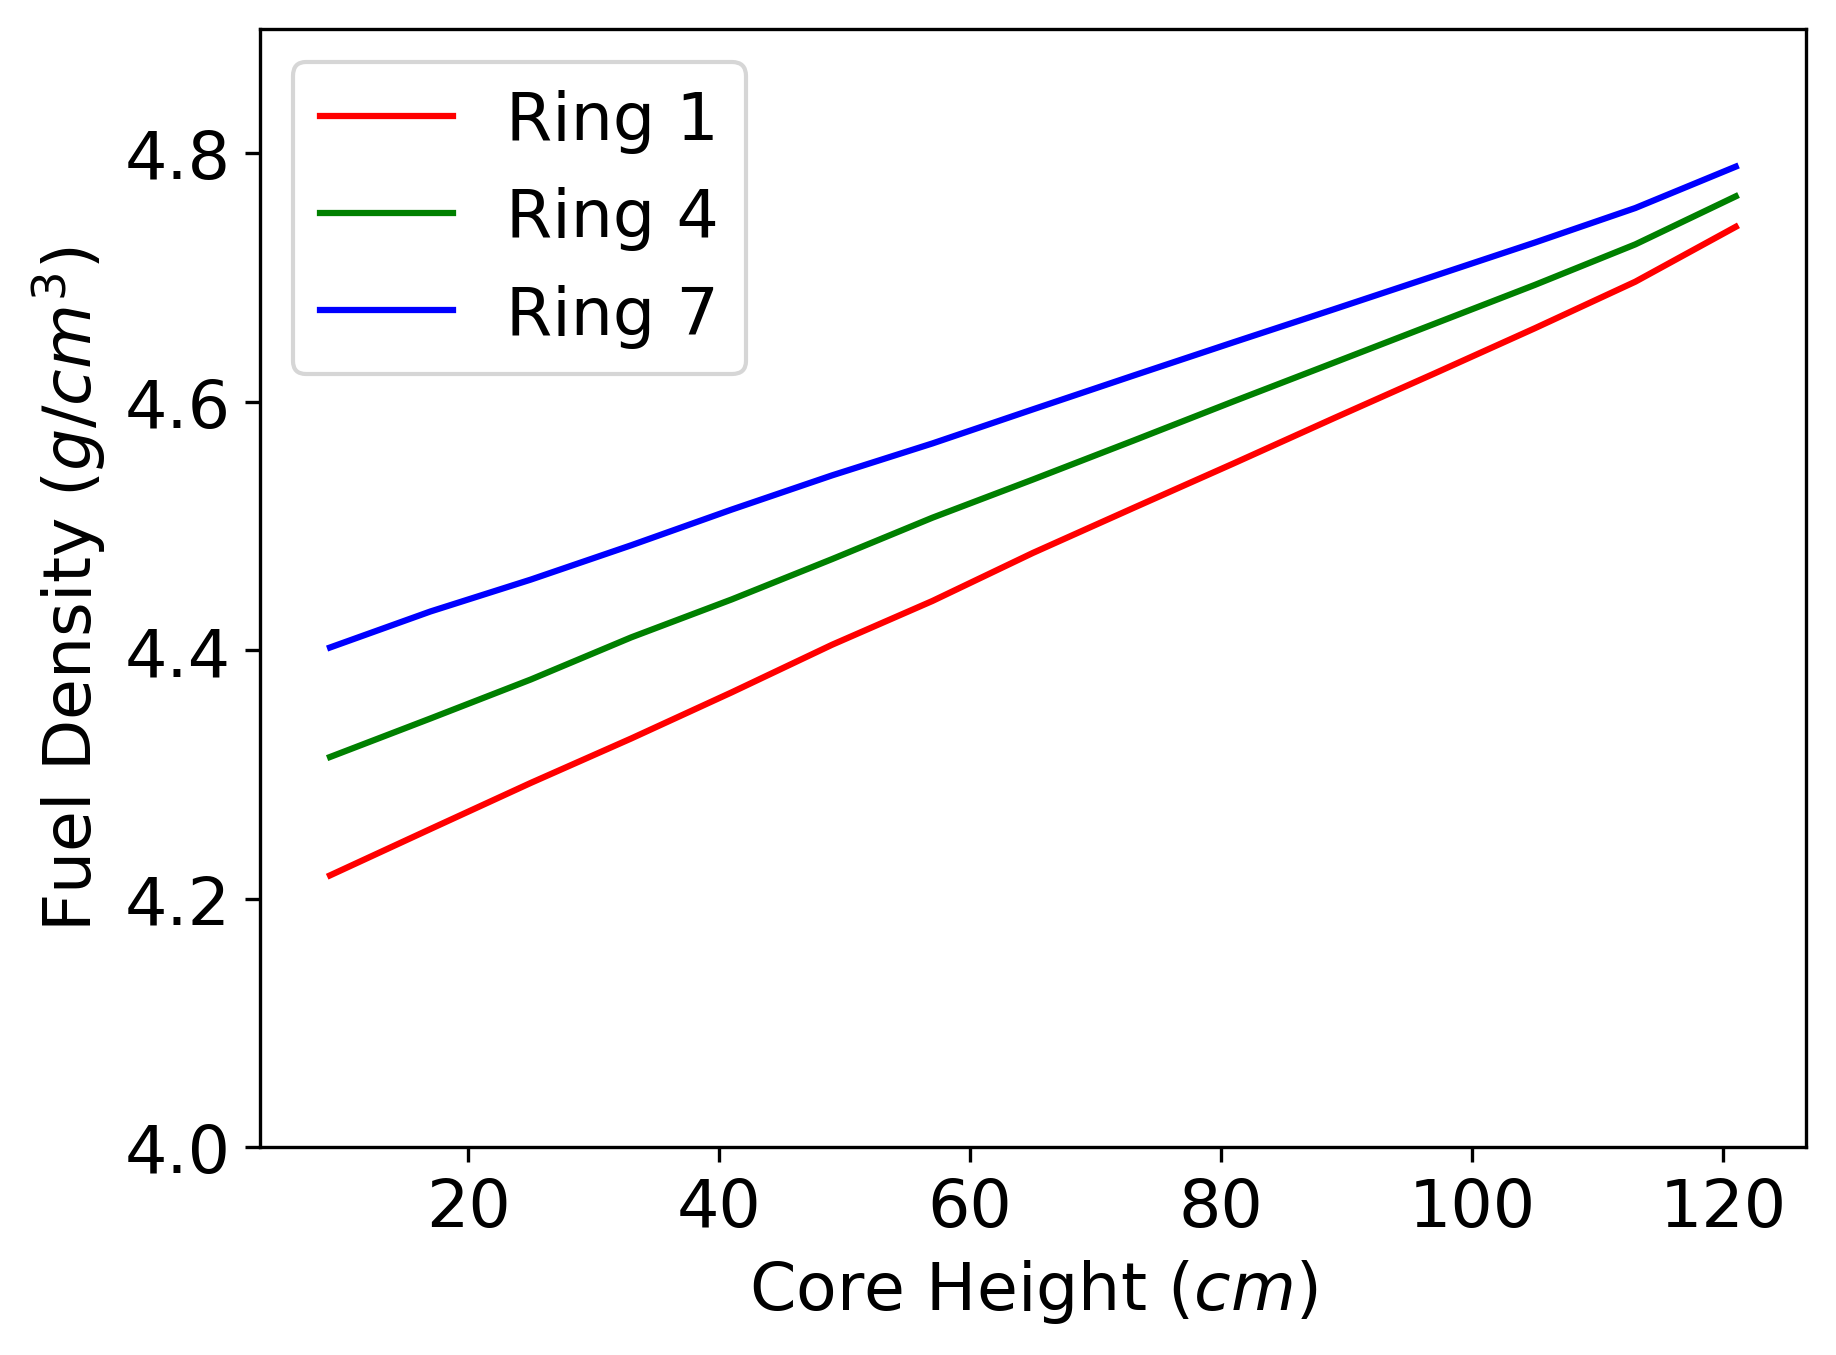

In [48]:
params = ("inp_", "inp_", "inp_")
states = ("0"   , "0"   , "0"   )
ids    = ("Df"  , "Df"  , "Df"  )

Df_data = get_vec_data(model,params,states,ids)
labels = ("Ring 1", "Ring 4", "Ring 7")

plt.figure()
plt.plot(zmid[1:-1],Df_data[0][mask6][1:-1],"r-")
plt.plot(zmid[1:-1],Df_data[1][mask3][1:-1],"g-")
plt.plot(zmid[1:-1],Df_data[2][mask0][1:-1],"b-")
plt.legend(labels)
plt.ylim([4,4.9])
plt.ylabel("Fuel Density ($g/cm^3$)")
plt.xlabel("Core Height ($cm$)")
plt.tight_layout()
plt.savefig(r"D:\OneDrive - Georgia Institute of Technology\Desktop\ETF_Journal\NTP_results\Df_state0.png")
plt.show()

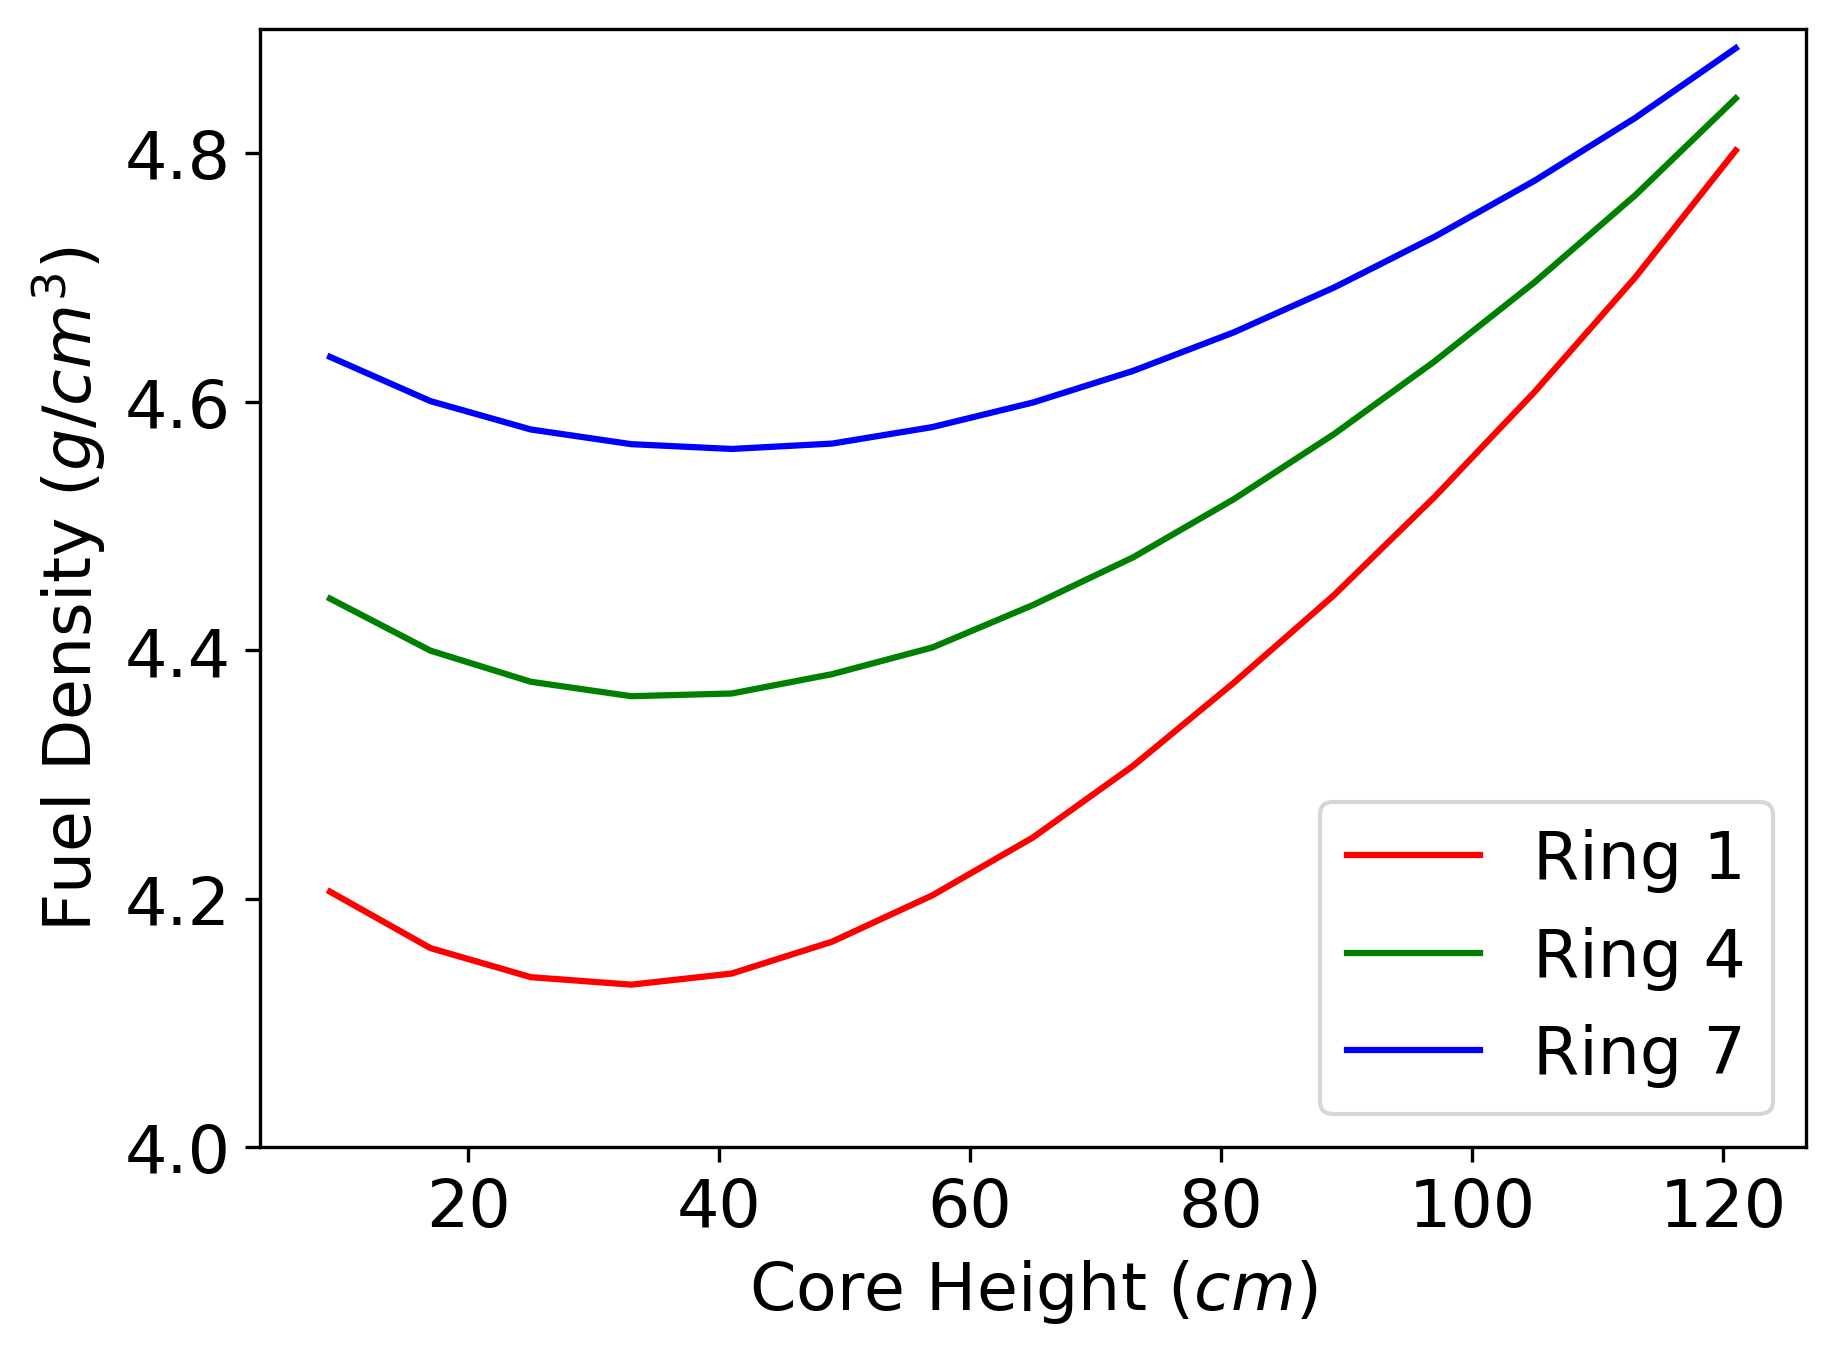

In [49]:
params = ("inp_", "inp_", "inp_")
states = ("2"   , "2"   , "2"   )
ids    = ("Df"  , "Df"  , "Df"  )

Df_data = get_vec_data(model,params,states,ids)
labels = ("Ring 1", "Ring 4", "Ring 7")

plt.figure()
plt.plot(zmid[1:-1],Df_data[0][mask6][1:-1],"r-")
plt.plot(zmid[1:-1],Df_data[1][mask3][1:-1],"g-")
plt.plot(zmid[1:-1],Df_data[2][mask0][1:-1],"b-")
plt.legend(labels)
plt.ylim([4,4.9])
plt.ylabel("Fuel Density ($g/cm^3$)")
plt.xlabel("Core Height ($cm$)")
plt.tight_layout()
plt.savefig(r"D:\OneDrive - Georgia Institute of Technology\Desktop\ETF_Journal\NTP_results\Df_state1.png")
plt.show()

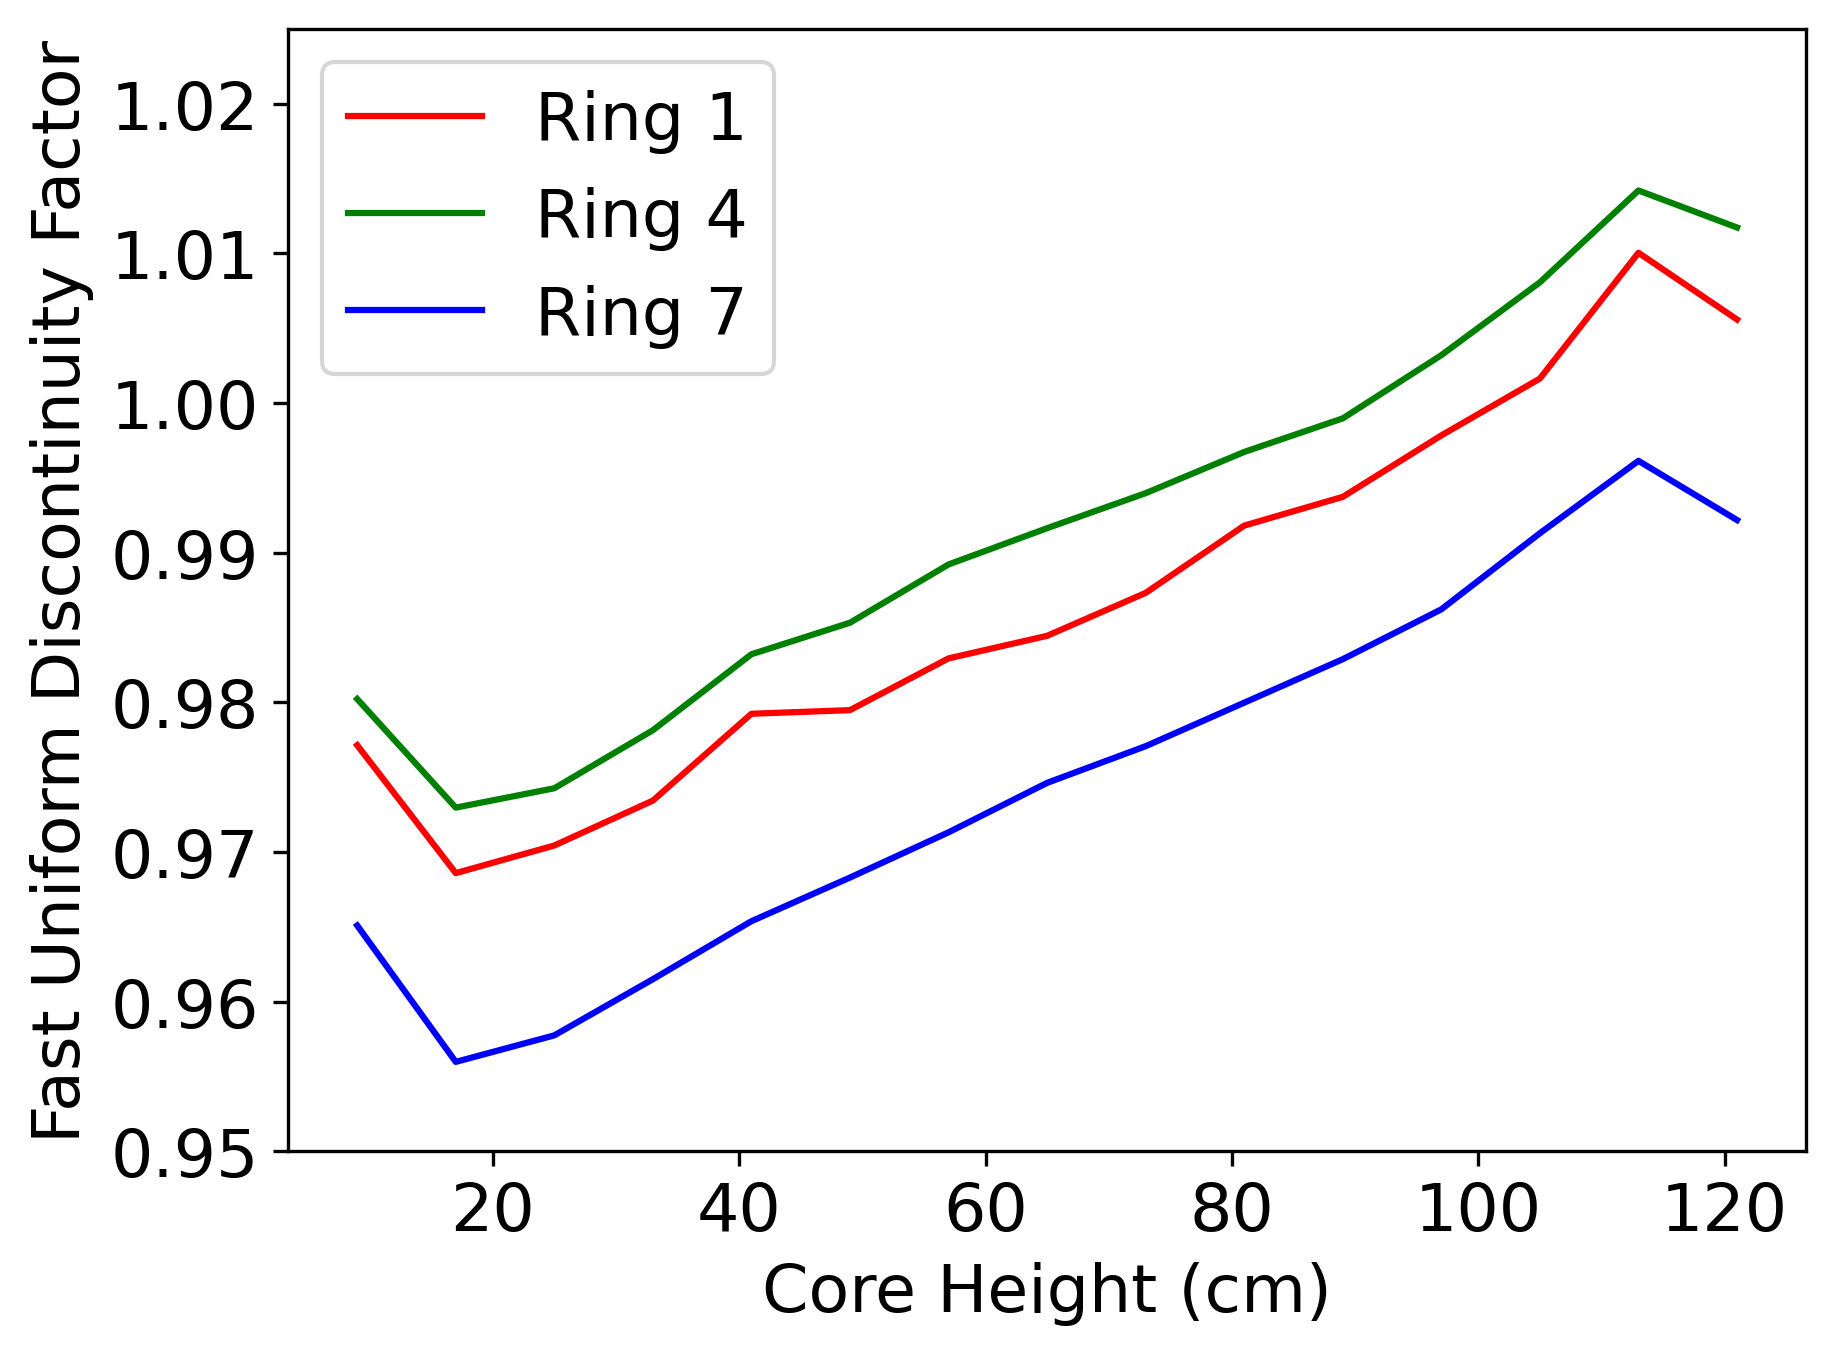

In [50]:
params = ("dep_"    ,)
states = ("0"       ,)
ids    = ("adf_g0"  ,)
labels = ("Ring 1","Ring 4","Ring 7")

xs_g0_data = get_vec_data(model,params,states,ids)

plt.figure()
plt.plot(zmid[1:-1],xs_g0_data[0][mask6][1:-1],"r-")
plt.plot(zmid[1:-1],xs_g0_data[0][mask3][1:-1],"g-")
plt.plot(zmid[1:-1],xs_g0_data[0][mask0][1:-1],"b-")
plt.legend(labels)
plt.ylabel("Fast Uniform Discontinuity Factor")
plt.xlabel("Core Height (cm)")
plt.ylim([0.95,1.025])
plt.tight_layout()
plt.tight_layout()
plt.savefig(r"D:\OneDrive - Georgia Institute of Technology\Desktop\ETF_Journal\NTP_results\udf_state0_g0.png")
plt.show()

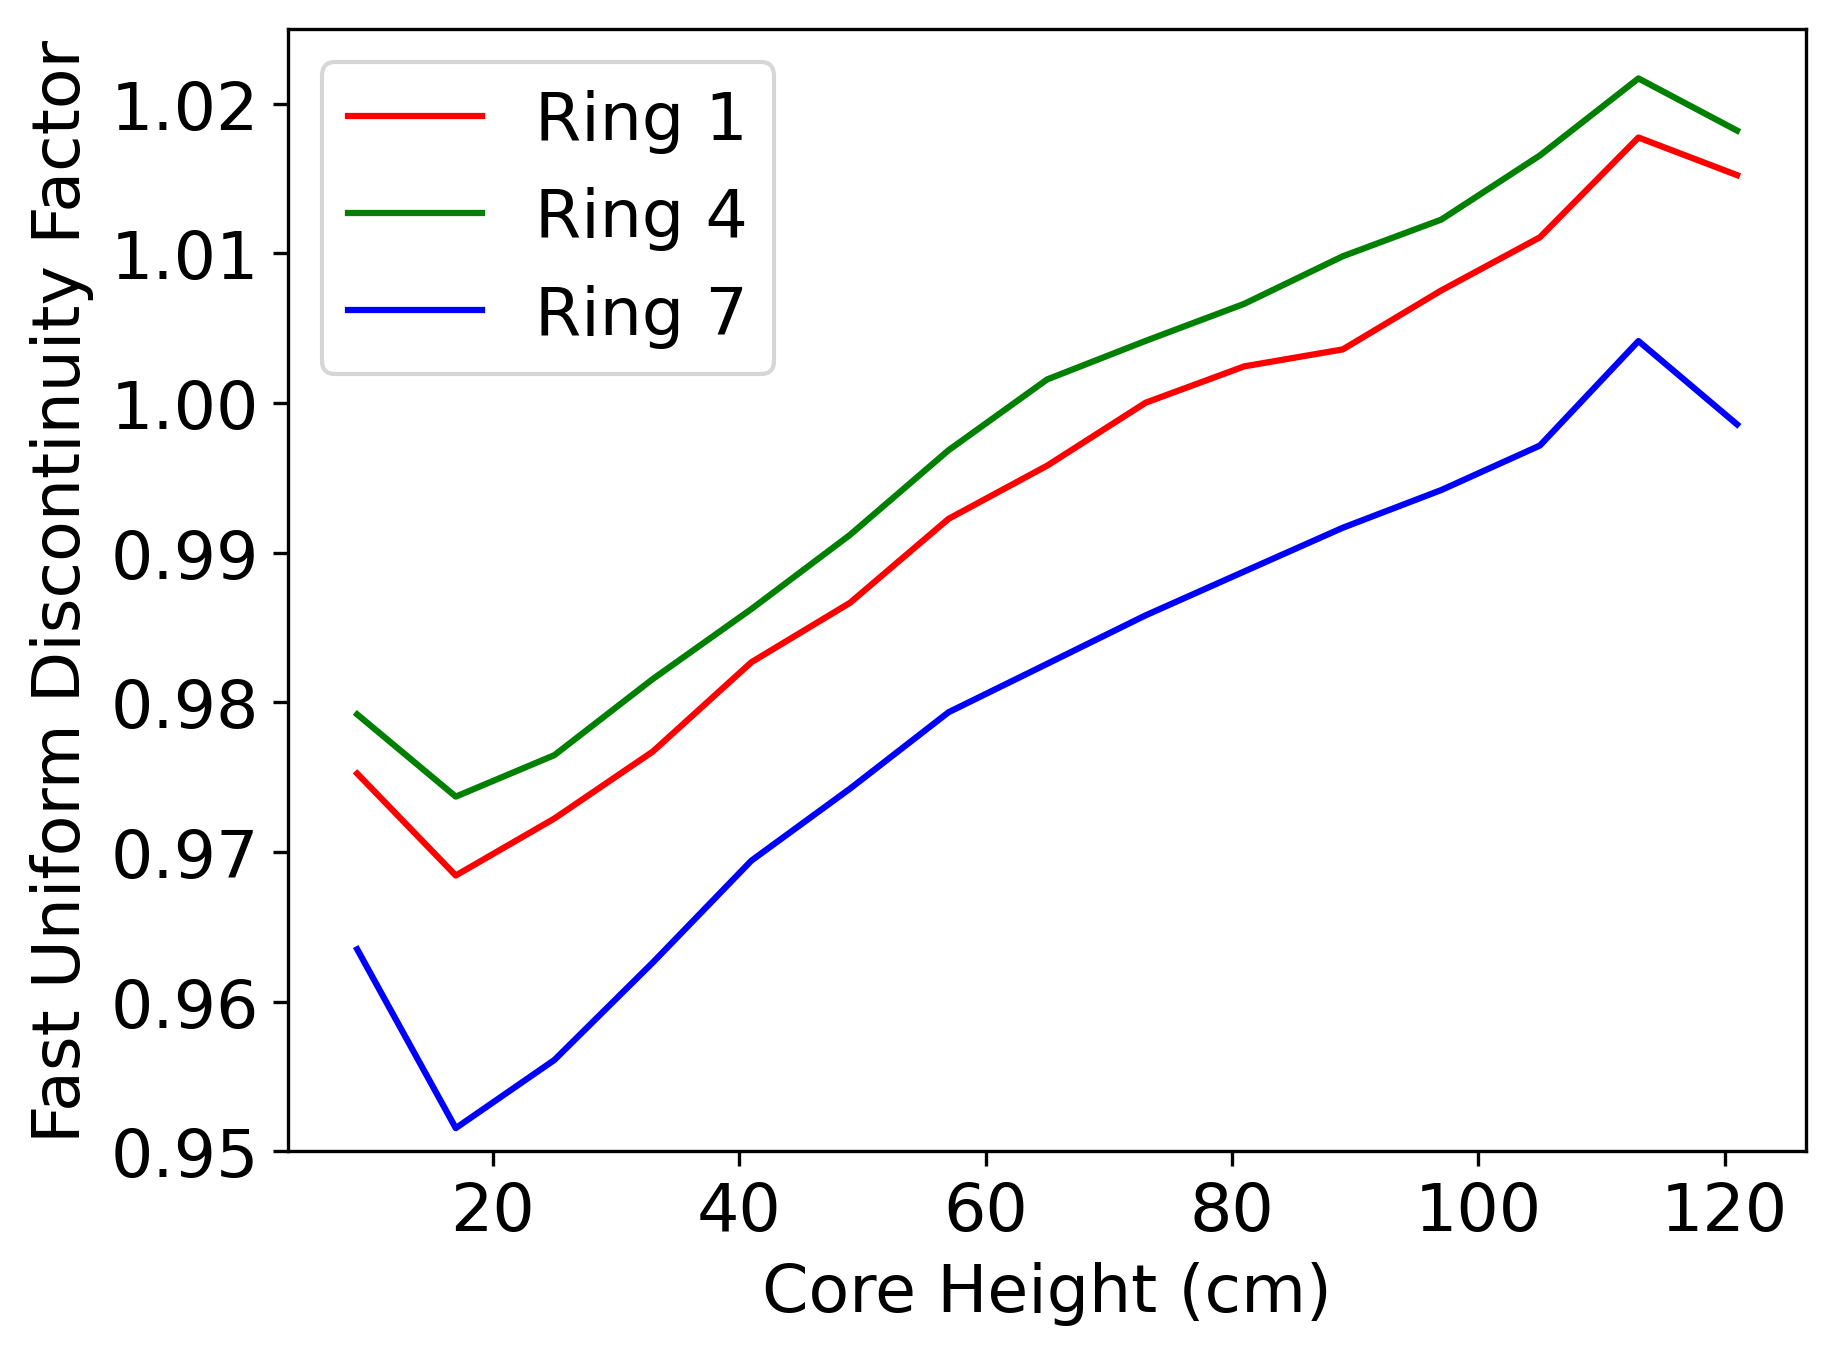

In [51]:
params = ("dep_"    ,)
states = ("2"       ,)
ids    = ("adf_g0"  ,)
labels = ("Ring 1","Ring 4","Ring 7")

xs_g0_data = get_vec_data(model,params,states,ids)

plt.figure()
plt.plot(zmid[1:-1],xs_g0_data[0][mask6][1:-1],"r-")
plt.plot(zmid[1:-1],xs_g0_data[0][mask3][1:-1],"g-")
plt.plot(zmid[1:-1],xs_g0_data[0][mask0][1:-1],"b-")
plt.legend(labels)
plt.ylabel("Fast Uniform Discontinuity Factor")
plt.xlabel("Core Height (cm)")
plt.ylim([0.95,1.025])
plt.tight_layout()
plt.tight_layout()
plt.savefig(r"D:\OneDrive - Georgia Institute of Technology\Desktop\ETF_Journal\NTP_results\udf_state1_g0.png")
plt.show()

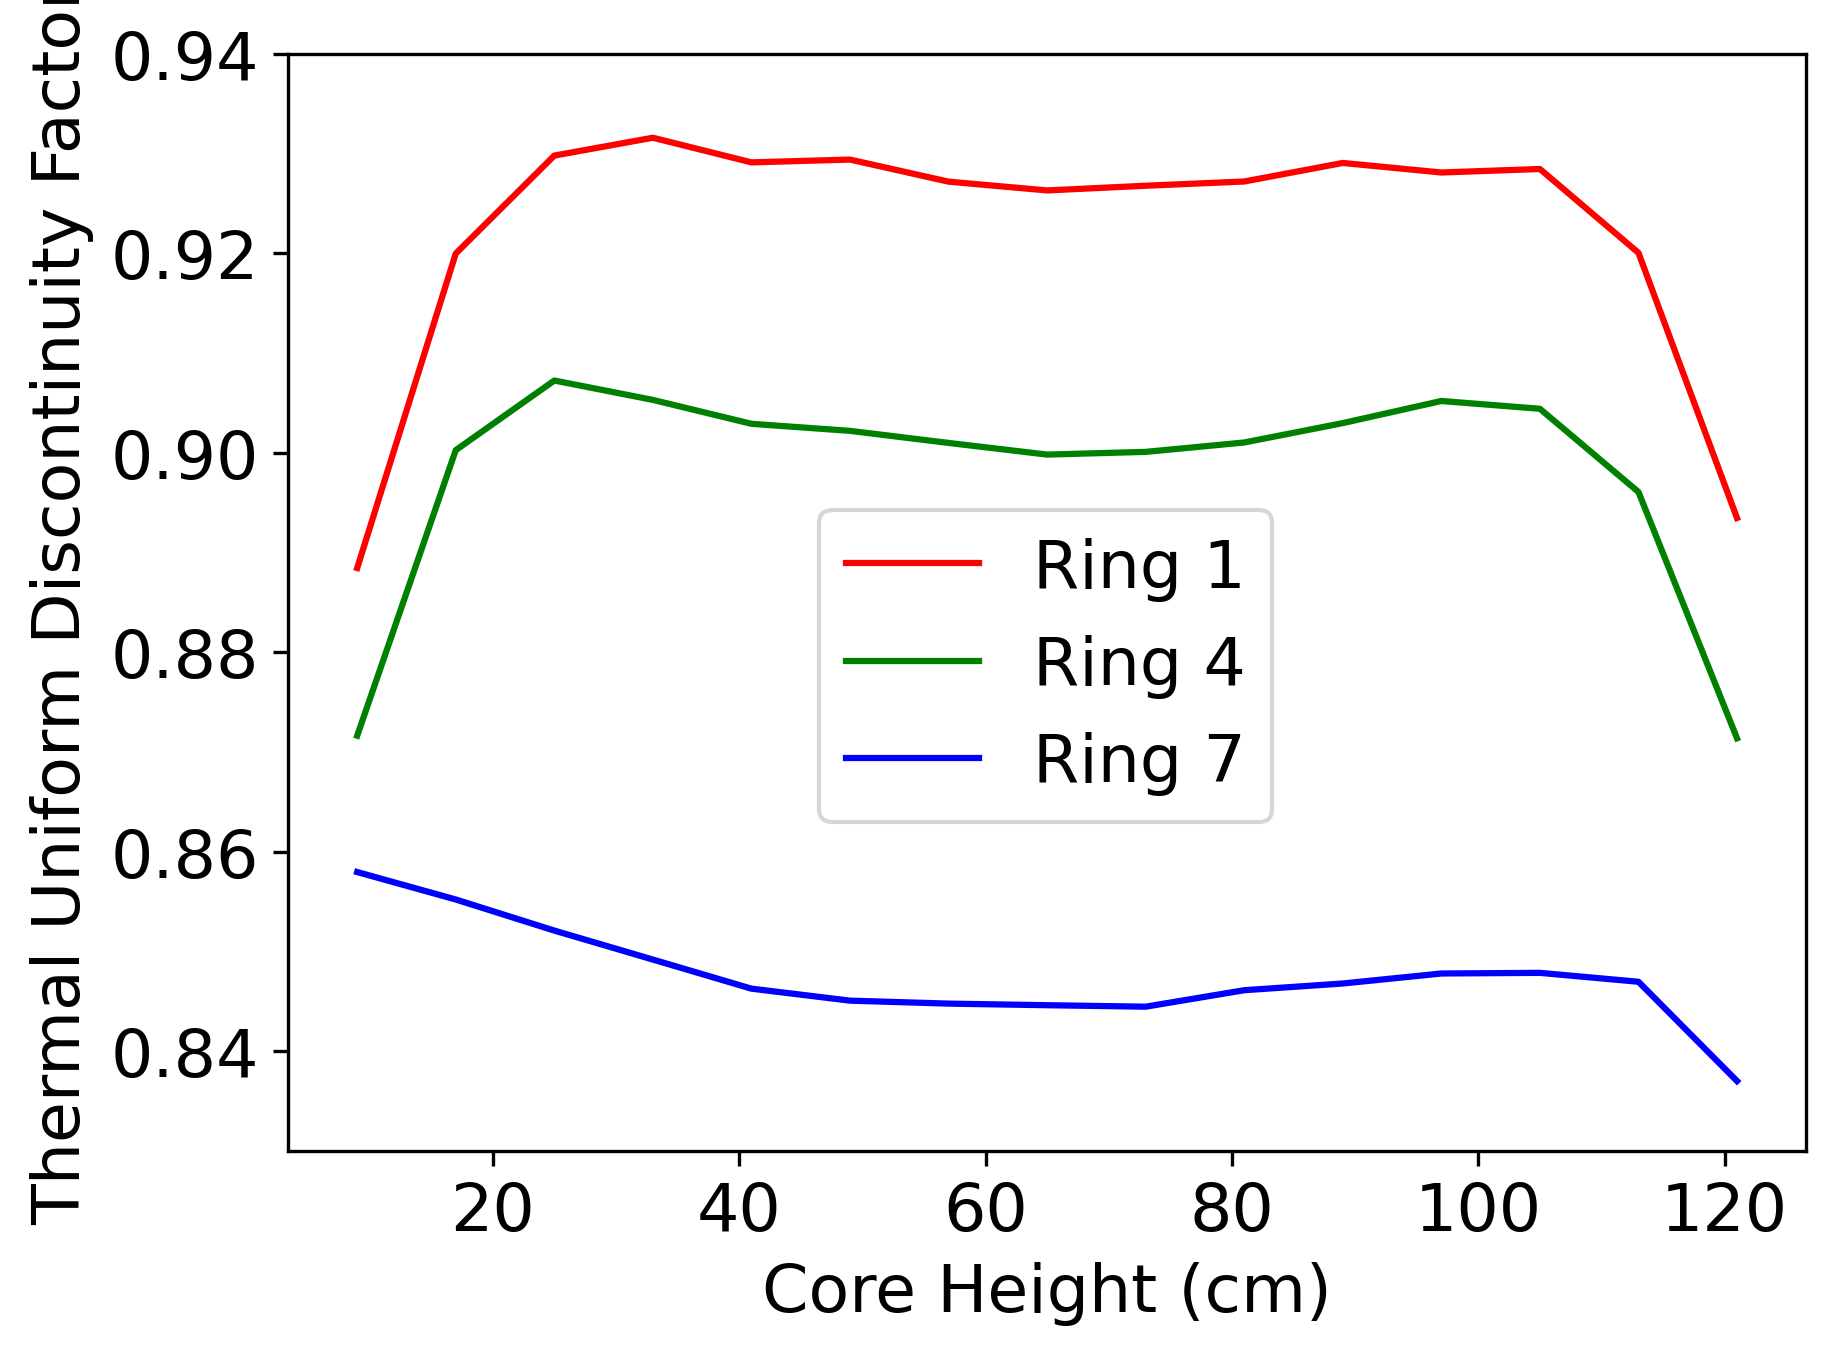

In [52]:
params = ("dep_"    ,)
states = ("0"       ,)
ids    = ("adf_g1"  ,)
labels = ("Ring 1","Ring 4","Ring 7")

xs_g1_data = get_vec_data(model,params,states,ids)

plt.figure()
plt.plot(zmid[1:-1],xs_g1_data[0][mask6][1:-1],"r-")
plt.plot(zmid[1:-1],xs_g1_data[0][mask3][1:-1],"g-")
plt.plot(zmid[1:-1],xs_g1_data[0][mask0][1:-1],"b-")
plt.legend(labels,loc=(0.35,0.3))
plt.ylabel("Thermal Uniform Discontinuity Factor")
plt.xlabel("Core Height (cm)")
plt.ylim([0.83,0.94])
plt.tight_layout()
plt.tight_layout()
plt.savefig(r"D:\OneDrive - Georgia Institute of Technology\Desktop\ETF_Journal\NTP_results\udf_state0_g1.png")
plt.show()

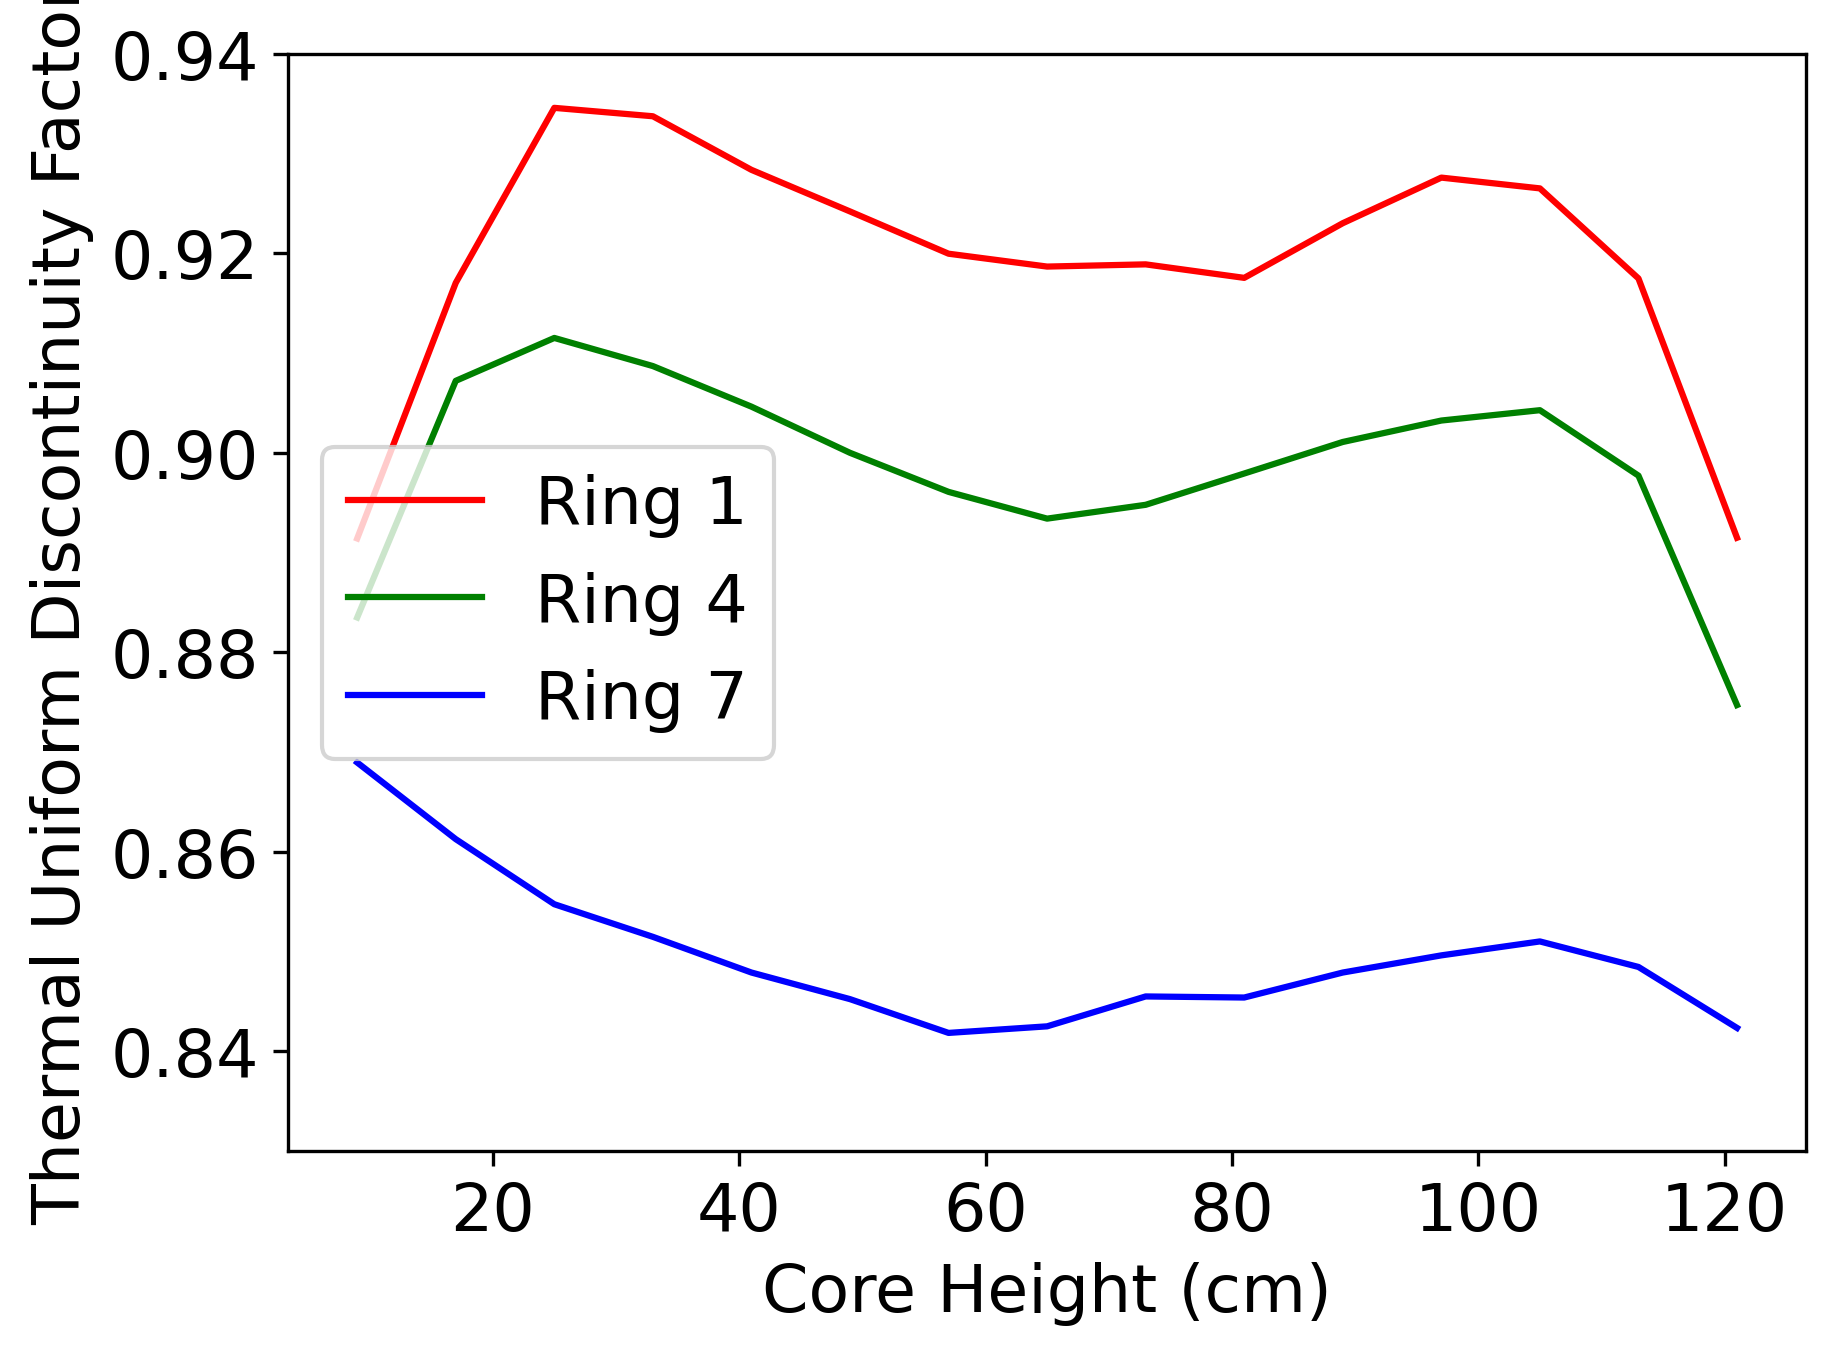

In [53]:
params = ("dep_"    ,)
states = ("2"       ,)
ids    = ("adf_g1"  ,)
labels = ("Ring 1","Ring 4","Ring 7")

xs_g1_data = get_vec_data(model,params,states,ids)

plt.figure()
plt.plot(zmid[1:-1],xs_g1_data[0][mask6][1:-1],"r-")
plt.plot(zmid[1:-1],xs_g1_data[0][mask3][1:-1],"g-")
plt.plot(zmid[1:-1],xs_g1_data[0][mask0][1:-1],"b-")
plt.legend(labels)
plt.ylabel("Thermal Uniform Discontinuity Factor")
plt.xlabel("Core Height (cm)")
plt.ylim([0.83,0.94])
plt.tight_layout()
plt.tight_layout()
plt.savefig(r"D:\OneDrive - Georgia Institute of Technology\Desktop\ETF_Journal\NTP_results\udf_state1_g1.png")
plt.show()

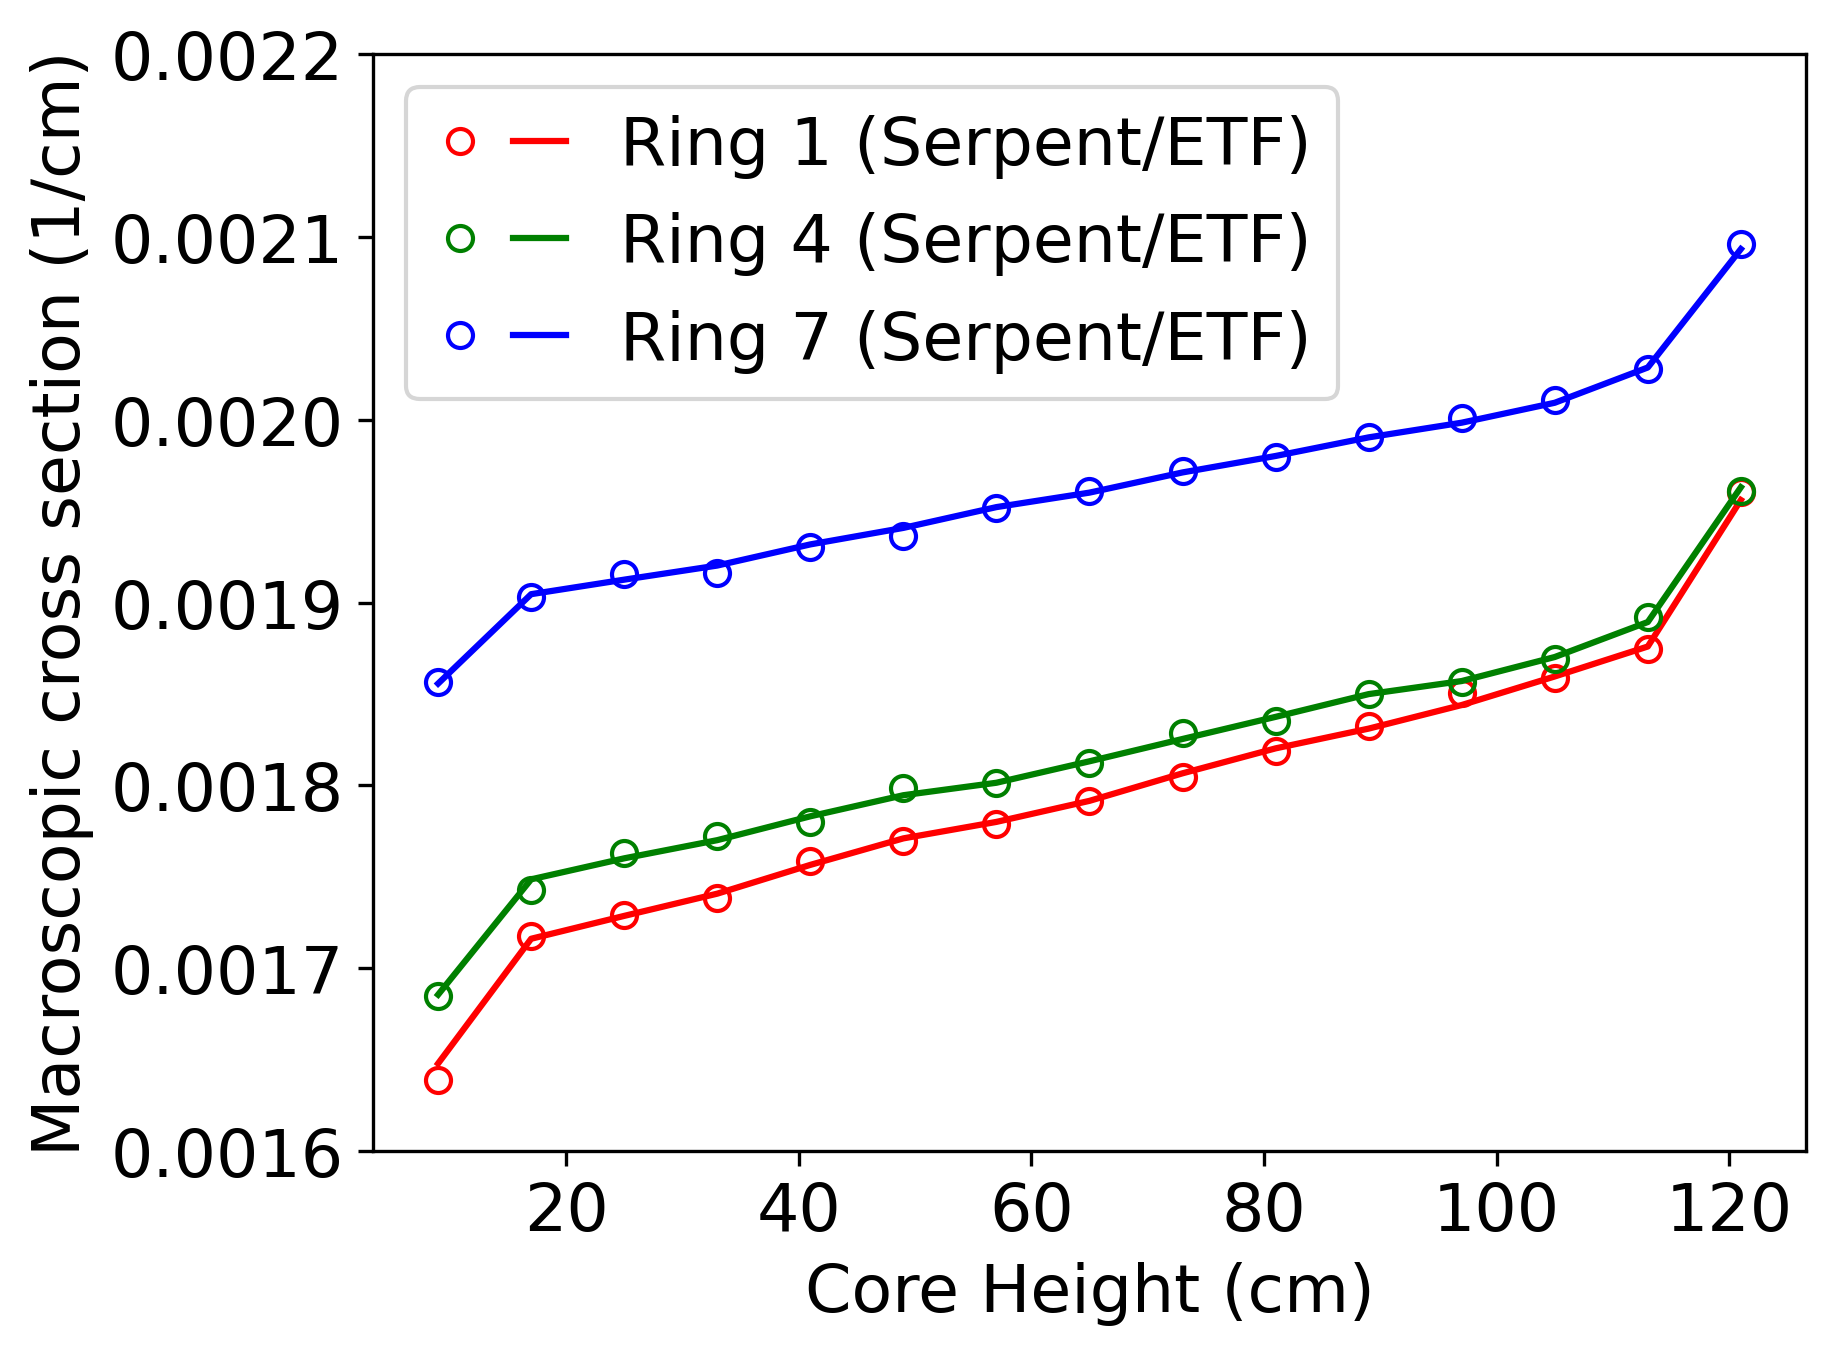

In [54]:
params = ("dep_"    ,"pre_")
states = ("0"       ,"0"   )
# ids    = ("rab_g0"  ,"rab_g0")
ids    = ("nsf_g0"  ,"nsf_g0"  )
# ids    = ("trp_g0"  ,"trp_g0")
# ids    = ("adf_g0"  ,"adf_g0")
labels = ("Ring 1 (Serpent)","Ring 1 (ETF)","Ring 4 (Serpent)","Ring 4 (ETF)","Ring 7 (Serpent)","Ring 7 (ETF)")

xs_g0_data = get_vec_data(model,params,states,ids)

fig,ax = plt.subplots(1,1)
r1, = ax.plot(zmid[1:-1],xs_g0_data[0][mask6][1:-1],"ro",markerfacecolor="None")
p1, = ax.plot(zmid[1:-1],xs_g0_data[1][mask6][1:-1],"r-")
r4, = ax.plot(zmid[1:-1],xs_g0_data[0][mask3][1:-1],"go",markerfacecolor="None")
p4, = ax.plot(zmid[1:-1],xs_g0_data[1][mask3][1:-1],"g-")
r7, = ax.plot(zmid[1:-1],xs_g0_data[0][mask0][1:-1],"bo",markerfacecolor="None")
p7, = ax.plot(zmid[1:-1],xs_g0_data[1][mask0][1:-1],"b-")
l   = ax.legend([(r1,p1), (r4,p4), (r7,p7)], ['Ring 1 (Serpent/ETF)', 'Ring 4 (Serpent/ETF)', 'Ring 7 (Serpent/ETF)'],
               handler_map={tuple: HandlerTuple(ndivide=None)})
plt.ylabel("Macroscopic cross section (1/cm)")
plt.xlabel("Core Height (cm)")
plt.ylim([0.0016,0.0022])
plt.tight_layout()
plt.savefig(r"D:\OneDrive - Georgia Institute of Technology\Desktop\ETF_Journal\NTP_results\nsf_state0_g0.png")
plt.show()

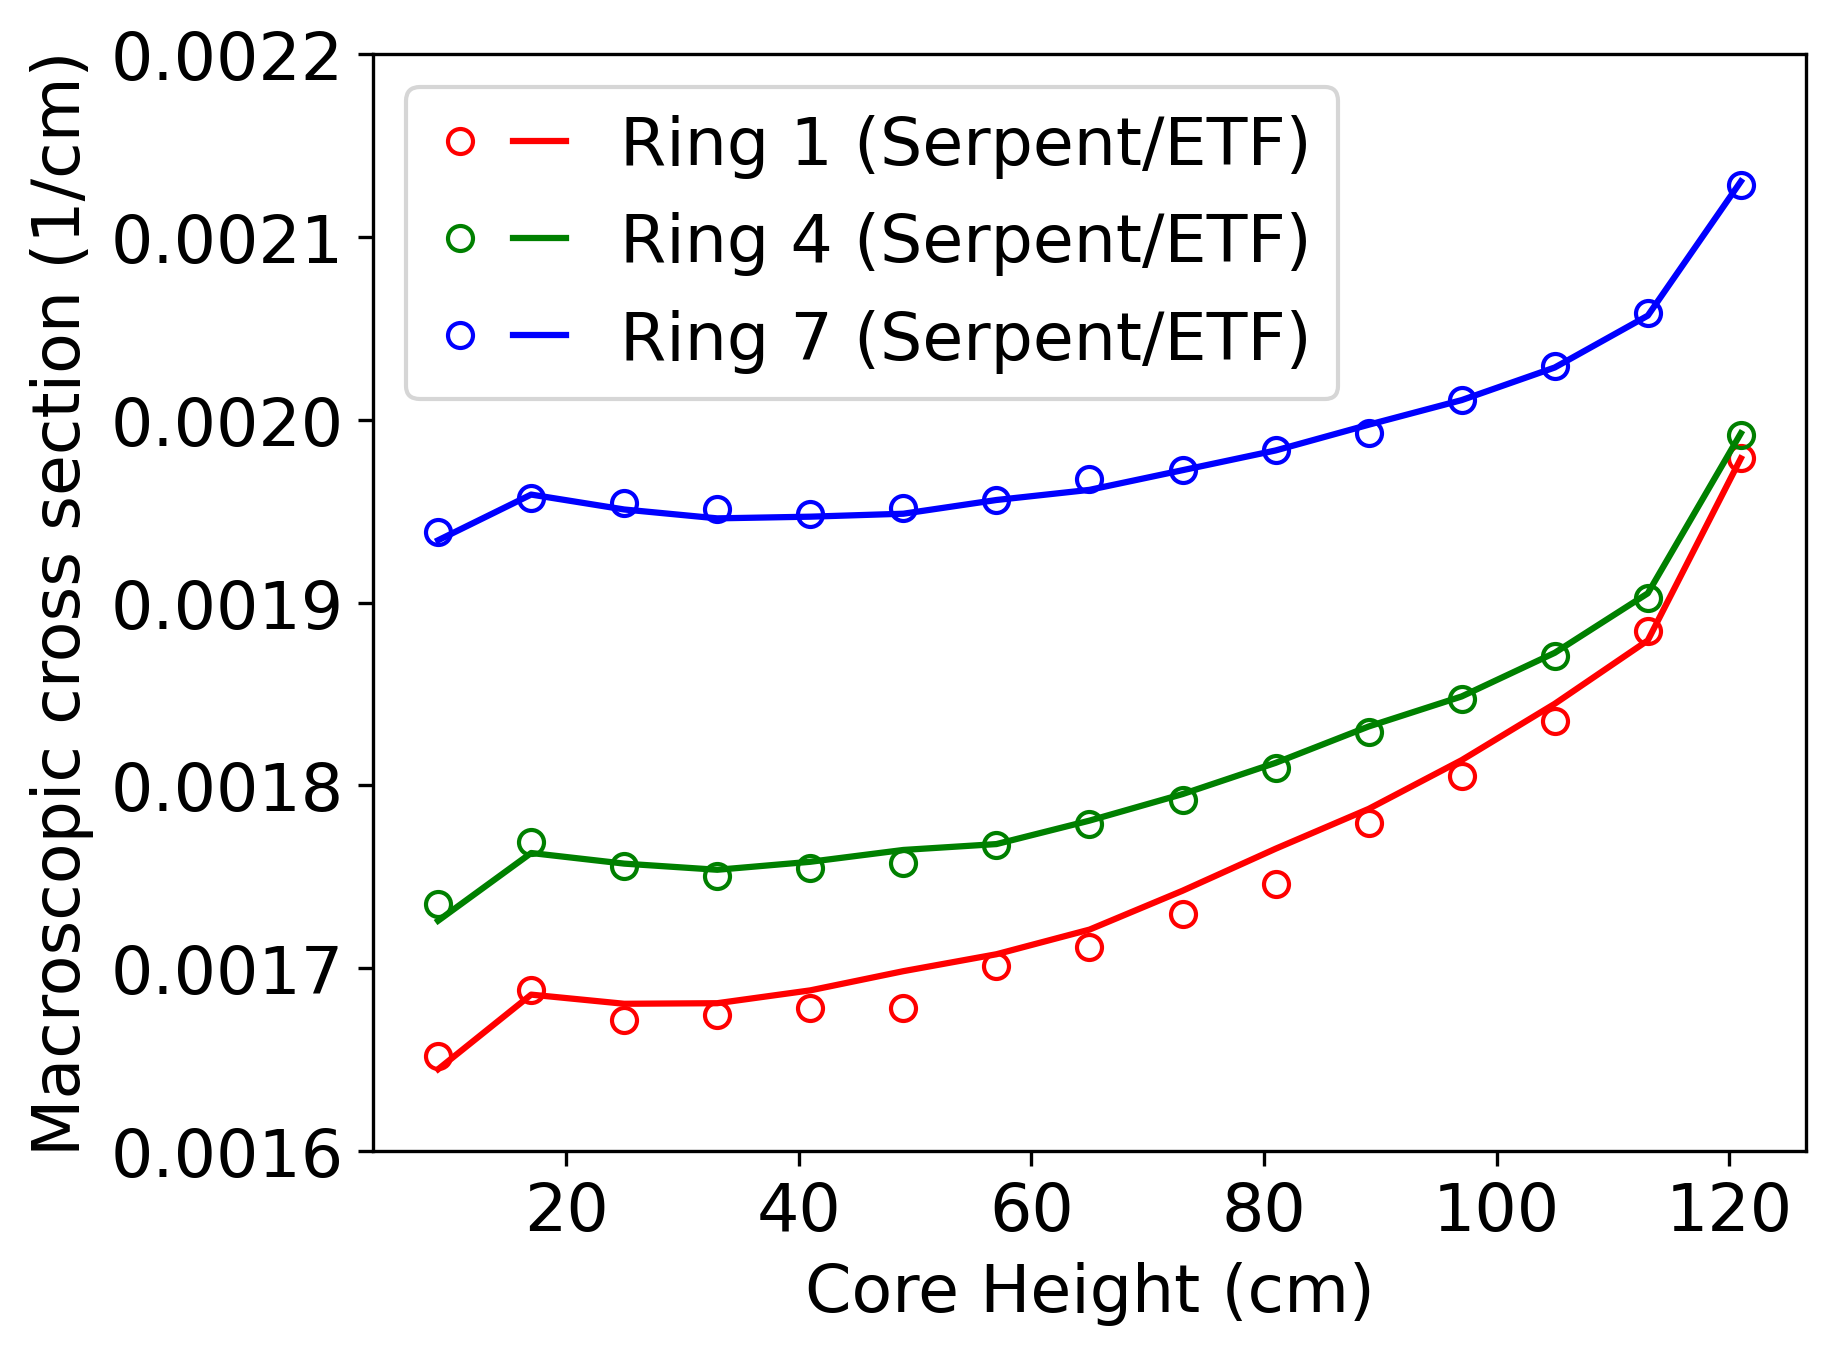

In [55]:
params = ("dep_"    ,"pre_")
states = ("2"       ,"2"   )
# ids    = ("rab_g0"  ,"rab_g0")
ids    = ("nsf_g0"  ,"nsf_g0"  )
# ids    = ("trp_g0"  ,"trp_g0")
# ids    = ("adf_g0"  ,"adf_g0")
labels = ("Ring 1 (Serpent)","Ring 1 (ETF)","Ring 4 (Serpent)","Ring 4 (ETF)","Ring 7 (Serpent)","Ring 7 (ETF)")

xs_g0_data = get_vec_data(model,params,states,ids)

fig,ax = plt.subplots(1,1)
r1, = ax.plot(zmid[1:-1],xs_g0_data[0][mask6][1:-1],"ro",markerfacecolor="None")
p1, = ax.plot(zmid[1:-1],xs_g0_data[1][mask6][1:-1],"r-")
r4, = ax.plot(zmid[1:-1],xs_g0_data[0][mask3][1:-1],"go",markerfacecolor="None")
p4, = ax.plot(zmid[1:-1],xs_g0_data[1][mask3][1:-1],"g-")
r7, = ax.plot(zmid[1:-1],xs_g0_data[0][mask0][1:-1],"bo",markerfacecolor="None")
p7, = ax.plot(zmid[1:-1],xs_g0_data[1][mask0][1:-1],"b-")
l   = ax.legend([(r1,p1), (r4,p4), (r7,p7)], ['Ring 1 (Serpent/ETF)', 'Ring 4 (Serpent/ETF)', 'Ring 7 (Serpent/ETF)'],
               handler_map={tuple: HandlerTuple(ndivide=None)})
plt.ylabel("Macroscopic cross section (1/cm)")
plt.xlabel("Core Height (cm)")
plt.ylim([0.0016,0.0022])
plt.tight_layout()
plt.savefig(r"D:\OneDrive - Georgia Institute of Technology\Desktop\ETF_Journal\NTP_results\nsf_state1_g0.png")
# plt.savefig(r"D:\OneDrive - Georgia Institute of Technology\Desktop\ETF_Journal\NTP_results\nsf_state1_g0_coarse.png")
plt.show()

In [56]:
np.mean(abs(1-xs_g0_data[1][maskf]/xs_g0_data[0][maskf]))*100

0.2466911185735725

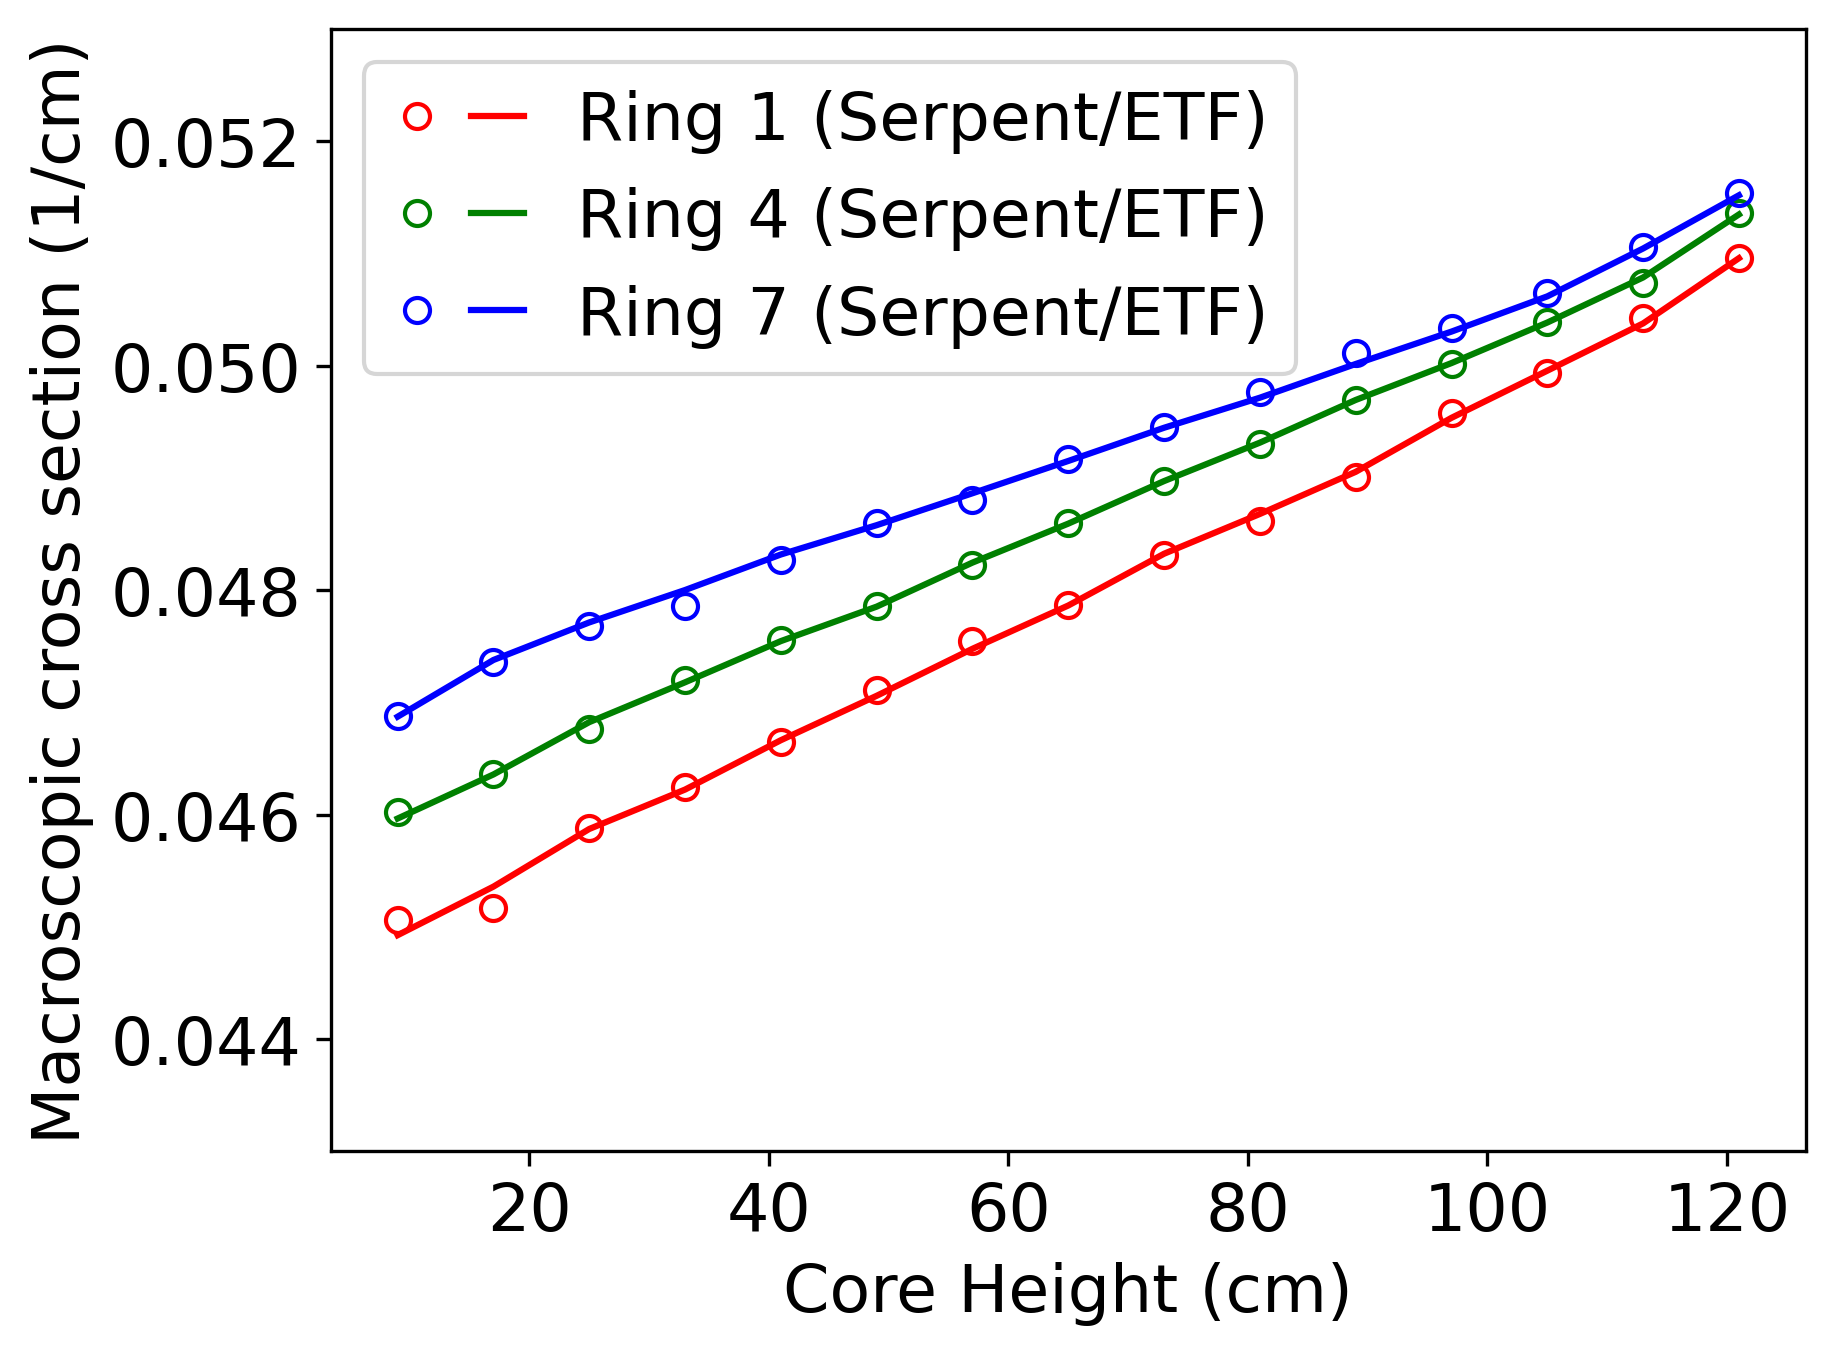

In [57]:
params = ("dep_"    ,"pre_")
states = ("0"       ,"0"   )
# ids    = ("rab_g1"  ,"rab_g1")
ids    = ("nsf_g1"  ,"nsf_g1")
# ids    = ("trp_g1"  ,"trp_g1")
# ids    = ("adf_g1"  ,"adf_g1")
labels = ("Ring 1 (Serpent)","Ring 1 (ETF)","Ring 4 (Serpent)","Ring 4 (ETF)","Ring 7 (Serpent)","Ring 7 (ETF)")

xs_g1_data = get_vec_data(model,params,states,ids)

fig,ax = plt.subplots(1,1)
r1, = ax.plot(zmid[1:-1],xs_g1_data[0][mask6][1:-1],"ro",markerfacecolor="None")
p1, = ax.plot(zmid[1:-1],xs_g1_data[1][mask6][1:-1],"r-")
r4, = ax.plot(zmid[1:-1],xs_g1_data[0][mask3][1:-1],"go",markerfacecolor="None")
p4, = ax.plot(zmid[1:-1],xs_g1_data[1][mask3][1:-1],"g-")
r7, = ax.plot(zmid[1:-1],xs_g1_data[0][mask0][1:-1],"bo",markerfacecolor="None")
p7, = ax.plot(zmid[1:-1],xs_g1_data[1][mask0][1:-1],"b-")
l   = ax.legend([(r1,p1), (r4,p4), (r7,p7)], ['Ring 1 (Serpent/ETF)', 'Ring 4 (Serpent/ETF)', 'Ring 7 (Serpent/ETF)'],
               handler_map={tuple: HandlerTuple(ndivide=None)})
plt.ylabel("Macroscopic cross section (1/cm)")
plt.xlabel("Core Height (cm)")
plt.ylim([0.043,0.053])
plt.tight_layout()
plt.savefig(r"D:\OneDrive - Georgia Institute of Technology\Desktop\ETF_Journal\NTP_results\nsf_state0_g1.png")
plt.show()

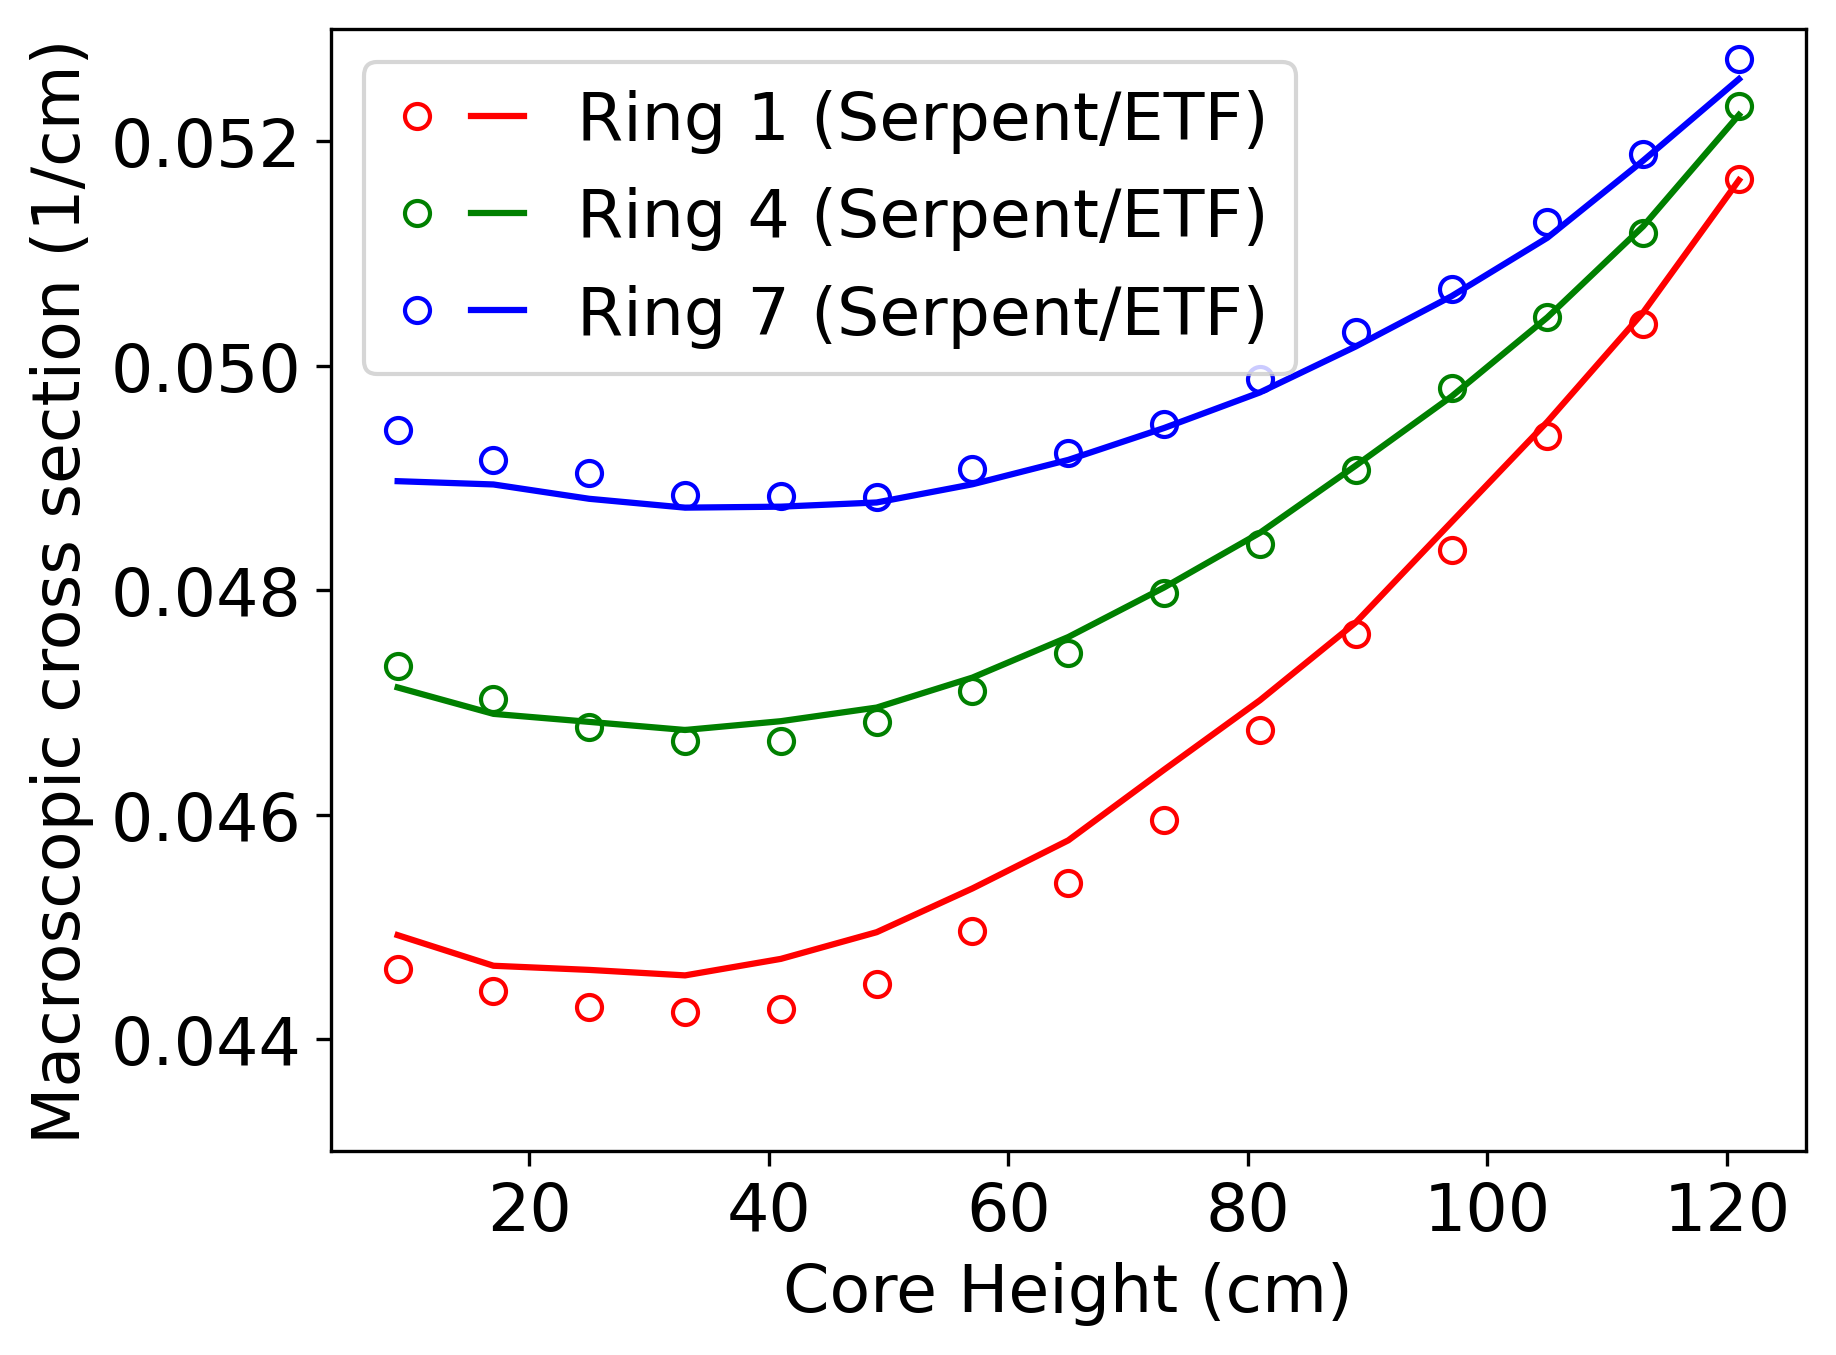

In [58]:
params = ("dep_"    ,"pre_")
states = ("2"       ,"2"   )
# ids    = ("rab_g1"  ,"rab_g1")
ids    = ("nsf_g1"  ,"nsf_g1")
# ids    = ("trp_g1"  ,"trp_g1")
# ids    = ("adf_g1"  ,"adf_g1")
labels = ("Ring 1 (Serpent)","Ring 1 (ETF)","Ring 4 (Serpent)","Ring 4 (ETF)","Ring 7 (Serpent)","Ring 7 (ETF)")

xs_g1_data = get_vec_data(model,params,states,ids)

fig,ax = plt.subplots(1,1)
r1, = ax.plot(zmid[1:-1],xs_g1_data[0][mask6][1:-1],"ro",markerfacecolor="None")
p1, = ax.plot(zmid[1:-1],xs_g1_data[1][mask6][1:-1],"r-")
r4, = ax.plot(zmid[1:-1],xs_g1_data[0][mask3][1:-1],"go",markerfacecolor="None")
p4, = ax.plot(zmid[1:-1],xs_g1_data[1][mask3][1:-1],"g-")
r7, = ax.plot(zmid[1:-1],xs_g1_data[0][mask0][1:-1],"bo",markerfacecolor="None")
p7, = ax.plot(zmid[1:-1],xs_g1_data[1][mask0][1:-1],"b-")
l   = ax.legend([(r1,p1), (r4,p4), (r7,p7)], ['Ring 1 (Serpent/ETF)', 'Ring 4 (Serpent/ETF)', 'Ring 7 (Serpent/ETF)'],
               handler_map={tuple: HandlerTuple(ndivide=None)})
plt.ylabel("Macroscopic cross section (1/cm)")
plt.xlabel("Core Height (cm)")
plt.ylim([0.043,0.053])
plt.tight_layout()
plt.savefig(r"D:\OneDrive - Georgia Institute of Technology\Desktop\ETF_Journal\NTP_results\nsf_state1_g1.png")
# plt.savefig(r"D:\OneDrive - Georgia Institute of Technology\Desktop\ETF_Journal\NTP_results\nsf_state1_g1_coarse.png")
plt.show()

In [59]:
np.mean(abs(1-xs_g1_data[1][maskf]/xs_g1_data[0][maskf]))*100

0.28439580368814793

### Execute DYN3D

In [60]:
# False, True
# True, True
# False, False
# True, False
predicted_xs = True
adf_type = "initial"

In [61]:
def xsfit_to_interface(model,univ_mat,attr,state,data_ids):
    """Formats data in an xsfit object into a xsInterface format

    Parameters
    ----------
    model - xsfit object
        model to pull data from
    univ_mat - 2d array
        maps each univ_id into each channel/layer index
    attr - str
        xsfit attribute to pull data from
        i.e., "indep_", "dep_", or "pre_"
    data_ids - list of str
        data_ids to pull from the attribute. multiple entries
        are appended together to represent MG data
        i.e., ["nsf_g0","nsf_g1"]

    """
    
    out = []
    ng = len(data_ids)
    nch,nly = np.shape(univ_mat)
    univ_vec = model.univ_.univ_vec
    
    # iterate through each channel
    for channel in univ_mat:
        mask = np.isin(univ_vec,channel)
        channel_data = np.zeros((nly,ng))
        for g,data_id in enumerate(data_ids):
            channel_data[:,g] = getattr(model,attr)[state].vecs[data_id][mask]
        out.append(channel_data)
    
    return out

In [62]:
# Grab predicted data and convert to xsInterface format
rab_pre = xsfit_to_interface(model,univ_mat,"pre_","2",["rab_g0","rab_g1"])
nsf_pre = xsfit_to_interface(model,univ_mat,"pre_","2",["nsf_g0","nsf_g1"])
trp_pre = xsfit_to_interface(model,univ_mat,"pre_","2",["trp_g0","trp_g1"])
scm_pre = xsfit_to_interface(model,univ_mat,"pre_","2",["scm_g0","scm_g1","scm_g2","scm_g3"])

In [63]:
# Create container for predicted state
userdata_2p = deepcopy(xs0r.core.corevalues)

# Pop incompatable data
userdata_2p.pop('adf',None)
userdata_2p.pop('lambda',None)
userdata_2p.pop('betaeff',None)

# Substitute predicted values in the fuel region
if predicted_xs:
    for i in range(7):
        userdata_2p['infrabsxs'][i][1:-1,:]   = rab_pre[i][1:-1,:]
        userdata_2p['infnsf'][i][1:-1,:]      = nsf_pre[i][1:-1,:]
        userdata_2p['inftranspxs'][i][1:-1,:] = trp_pre[i][1:-1,:]
        userdata_2p['infsp0'][i][1:-1,:]      = scm_pre[i][1:-1,:]

controlFile = roots[it0]+r"\inputs\controlDict"
casedir = roots[it0]+r"\dyn3d"   # dyn3d dir
casefile = "ntpcore"  # name of dyn3d file
exefile = "RUN_DYN3D" # dyn3d executuin file

# Read the control dict
xs2p = Main(controlFile)

# Read xs data and templates and populate with serpent data
xs2p.Read(userdata=userdata_2p)

nchs = 12
nlayers = 17
states = {
'history':[['nom']*nlayers]*nchs,
'time': [[0.0]*nlayers]*nchs,
'dens': [[700.]*nlayers]*nchs,
}

volmanip = {'infflx': 'divide'}

# This will populate datafiles and corevalues with the new pandasTable values. It will NOT update .macro in each universe
# This will populate datafiles and corevalues with the specified adfs
if adf_type=="initial":
    xs2p.PopulateCoreData(
                        states=states, 
                        attributes=None,  # specify only if specific attrs needed
                        volManip=volmanip,
                        adf=xs0r.core.corevalues['adf'],**userdata_2p)
elif adf_type=="perturbed":
    xs2p.PopulateCoreData(
                        states=states, 
                        attributes=None,  # specify only if specific attrs needed
                        volManip=volmanip,
                        adf=xs2r.core.corevalues['adf'],**userdata_2p)
else:
    xs2p.PopulateCoreData(
                        states=states, 
                        attributes=None,  # specify only if specific attrs needed
                        volManip=volmanip,
                        adf=None,**userdata_2p)

SERPENT Serpent 2.2.1 found in ./data/p100_pp_10unifax/ntp_core_3d_rings_res.m, but version 2.1.31 is defined in settings
  Attemping to read anyway. Please report strange behaviors/failures to developers.


... Reading control dict ...
<data/P100_pp_10unifAx\inputs\controlDict>

... Reading universe <u> ...
... Reading coe/_res.m file for hisotry <nom> ...


In [64]:
# execute dyn3d
start = time.time()
reslt = DYN3D(xs2p, casedir, casefile, exefile)
reslt.Execute()
end = time.time()
start-end

... DYN3D Execution ... Start
... DYN3D Execution ... Ended Successfully


-17.67975091934204

In [65]:
# Calculate a kappa in terms of joules
kj0r = np.array(xs0r.core.corevalues['infkappa'])*1.60218e-13
kj2r = np.array(xs2r.core.corevalues['infkappa'])*1.60218e-13

# Calculate volumes
nhexes = np.array([36,30,24,18,12,6,1,0,0,0,0,0])
A = np.sqrt(3)/2*P**2
vol = (A*dz).reshape((-1,1))
vol = np.hstack((vol,vol))

vols = []
for nhex in nhexes:
    vols.append(nhex*vol)
vols = np.array(vols)

In [66]:
# Calculate power production
power = 333426800.000
kpf0  = kj0r*np.array(xs0r.core.corevalues['inffiss'])
kpf2  = kj2r*np.array(xs2r.core.corevalues['inffiss'])
flx0r = np.array(xs0r.core.corevalues['infflx'])
flx2p = np.array(reslt.flux)
flx2r = np.array(xs2r.core.corevalues['infflx'])

# Calculate normalized power
pwr0r = flx0r*kpf0*vols/np.sum(flx0r*kpf0*vols)*power
pwr2p = flx2p*kpf2*vols/np.sum(flx2p*kpf2*vols)*power
pwr2r = flx2r*kpf2*vols/np.sum(flx2r*kpf2*vols)*power

# Sum power over groups
pwr0r = np.sum(pwr0r,axis=2)
pwr2p = np.sum(pwr2p,axis=2)
pwr2r = np.sum(pwr2r,axis=2)

# % Error in power
mask = pwr0r!=0
err0r = (pwr0r[mask]/pwr2r[mask]-1)*100
err2p = (pwr2p[mask]/pwr2r[mask]-1)*100

In [67]:
np.mean(abs(err0r)),np.mean(abs(err2p))

(1.8097245182111428, 0.3245173987069543)

In [68]:
np.linalg.norm(err0r)/np.linalg.norm(err2p)

4.58080139583194

In [69]:
# Compare reactivity
k0r = xs0r.core.corevalues['abskeff'][0][0][0]
k2p = reslt.keff
k2r = xs2r.core.corevalues['abskeff'][0][0][0]

rho0r = 1-1/k0r
rho2p = 1-1/k2p
rho2r = 1-1/k2r

(rho0r-rho2r)*1e5, (rho2p-rho2r)*1e5

(190.50560076038226, 18.375275930837542)

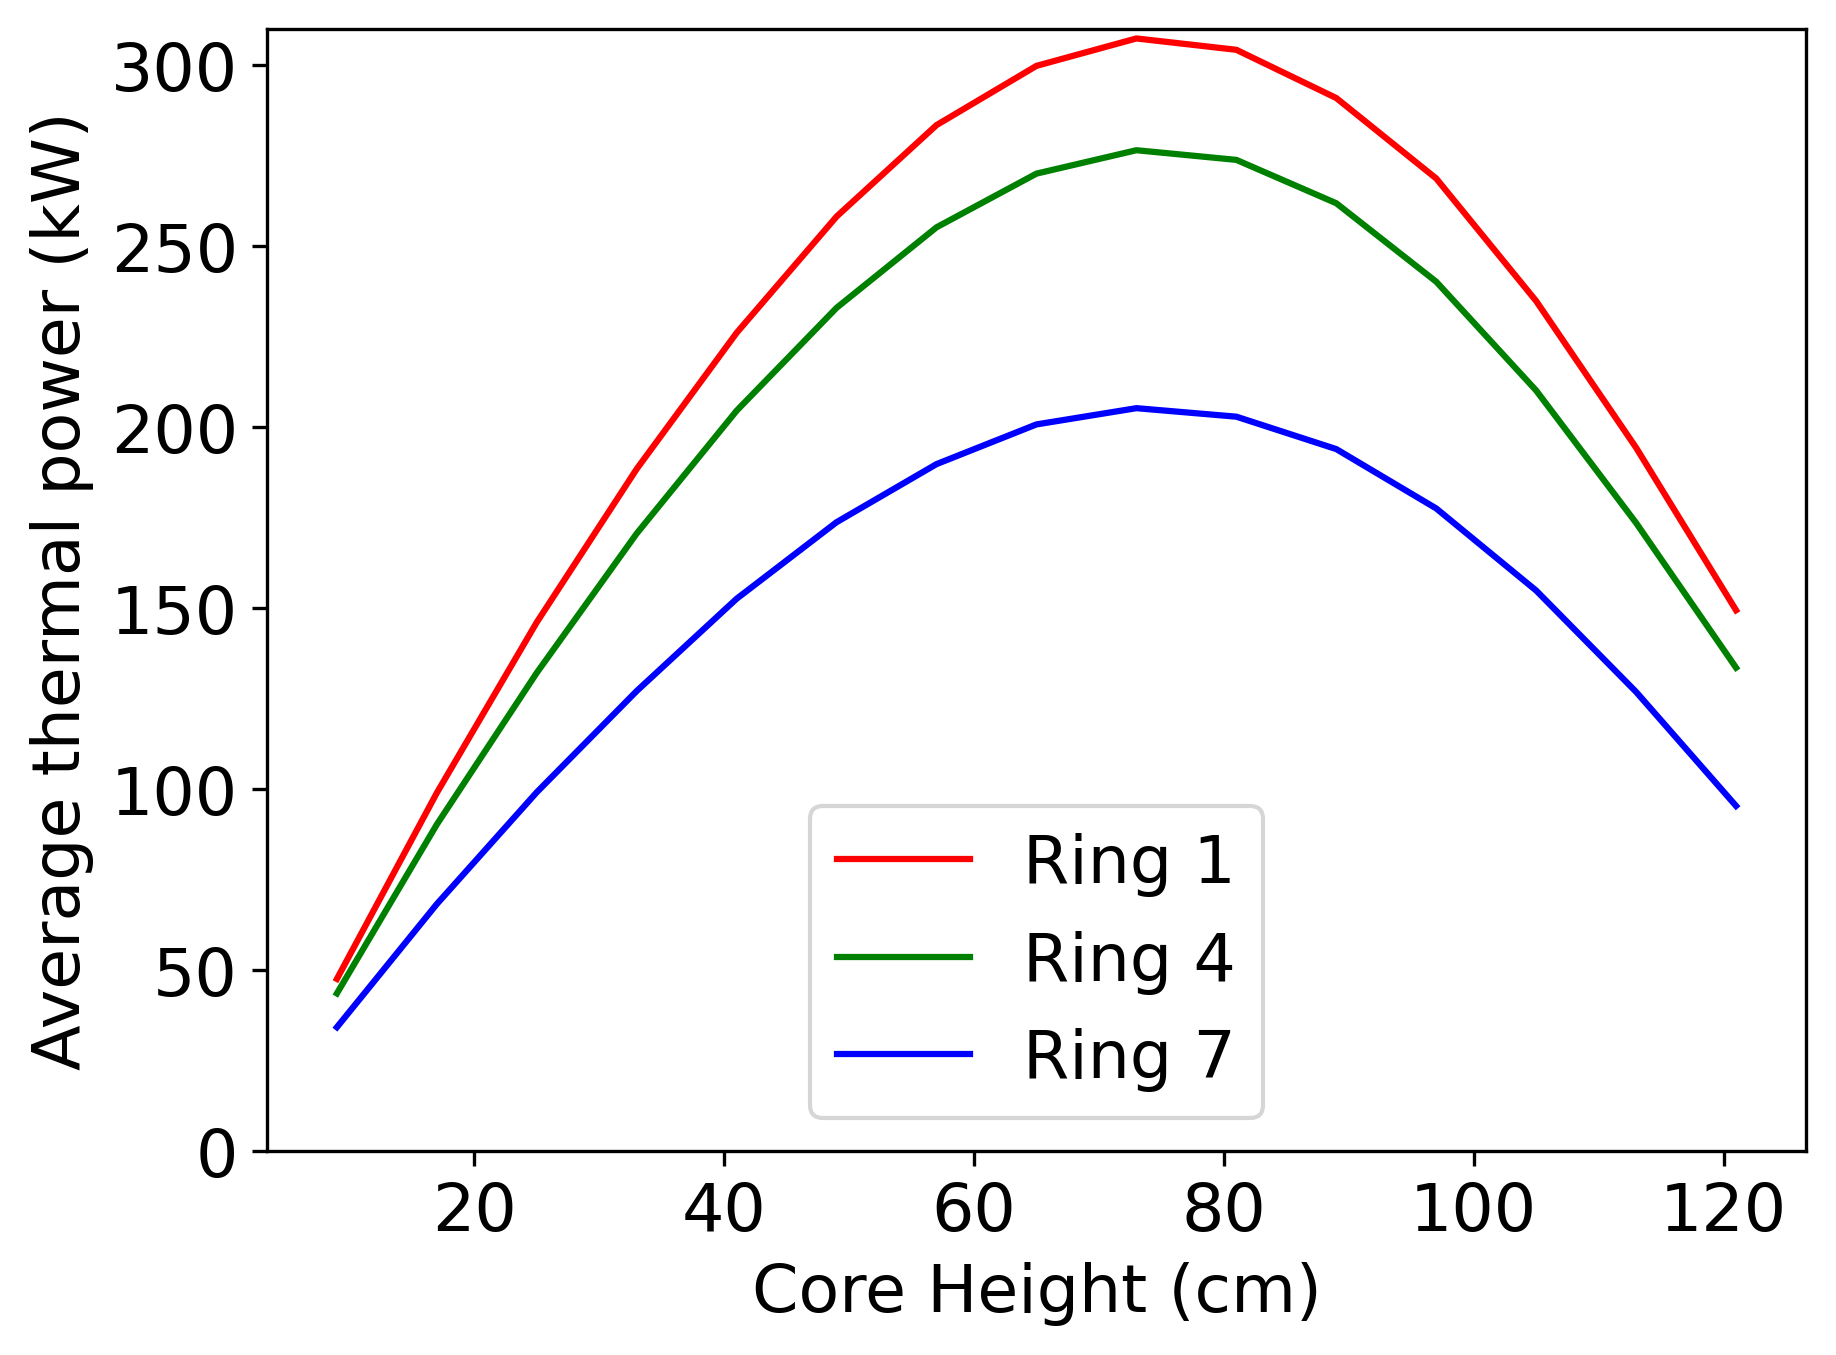

In [70]:
plt.plot(zmid[1:-1],pwr0r[6,1:-1]/nhexes[6]*1e-3,'r-')
plt.plot(zmid[1:-1],pwr0r[3,1:-1]/nhexes[3]*1e-3,'g-')
plt.plot(zmid[1:-1],pwr0r[0,1:-1]/nhexes[0]*1e-3,'b-',markerfacecolor="None")
plt.legend(["Ring 1","Ring 4","Ring 7"])
plt.ylabel("Average thermal power (kW)")
plt.xlabel("Core Height (cm)")
plt.ylim([0,310])
plt.tight_layout()
plt.savefig(r"D:\OneDrive - Georgia Institute of Technology\Desktop\ETF_Journal\NTP_results\power_state0.png")
plt.show()

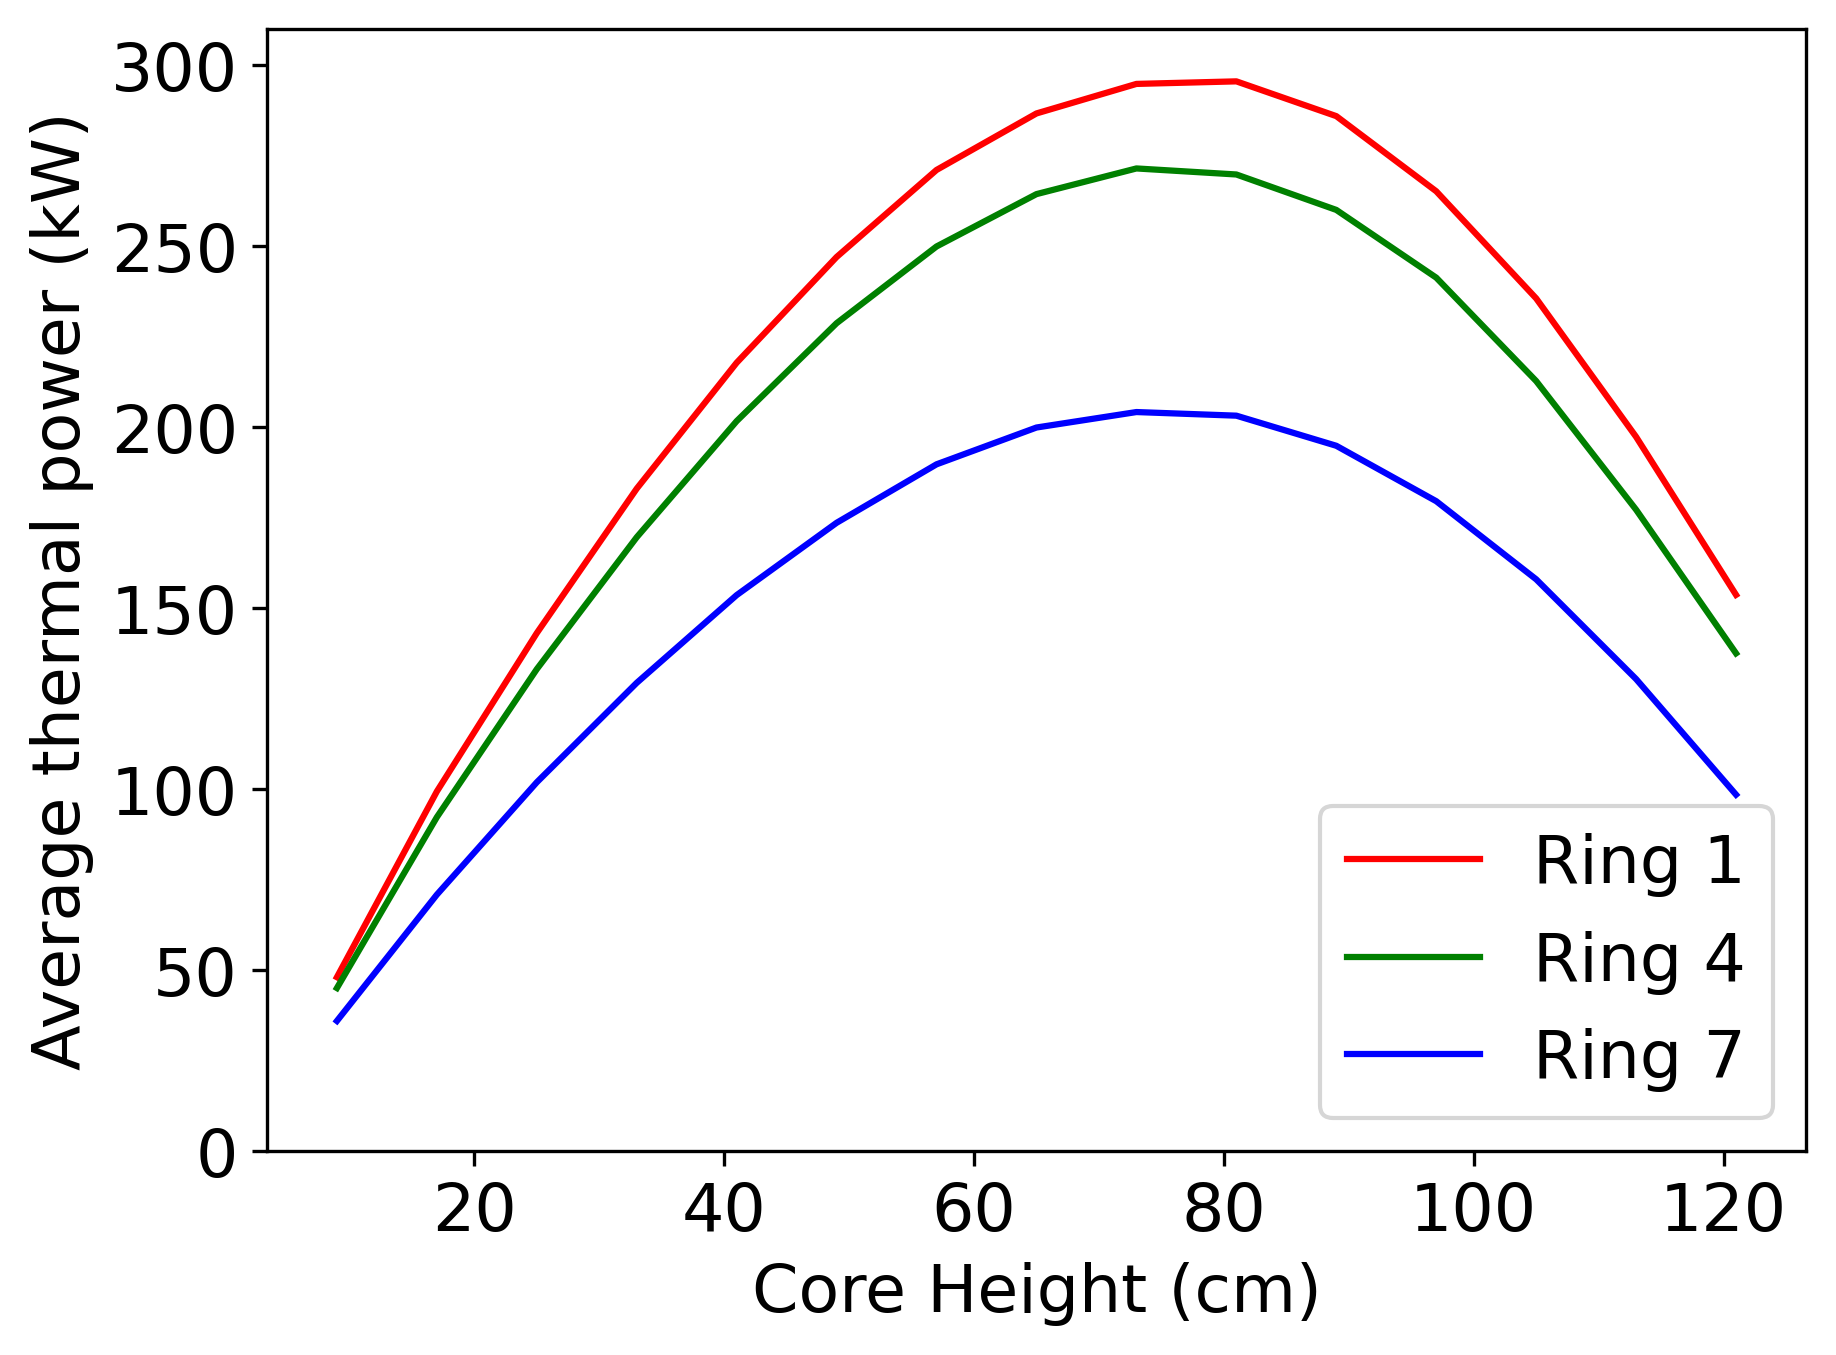

In [71]:
plt.plot(zmid[1:-1],pwr2r[6,1:-1]/nhexes[6]*1e-3,'r-')
plt.plot(zmid[1:-1],pwr2r[3,1:-1]/nhexes[3]*1e-3,'g-')
plt.plot(zmid[1:-1],pwr2r[0,1:-1]/nhexes[0]*1e-3,'b-',markerfacecolor="None")
plt.legend(["Ring 1","Ring 4","Ring 7"])
plt.ylabel("Average thermal power (kW)")
plt.xlabel("Core Height (cm)")
plt.ylim([0,310])
plt.tight_layout()
plt.savefig(r"D:\OneDrive - Georgia Institute of Technology\Desktop\ETF_Journal\NTP_results\power_state1.png")
plt.show()

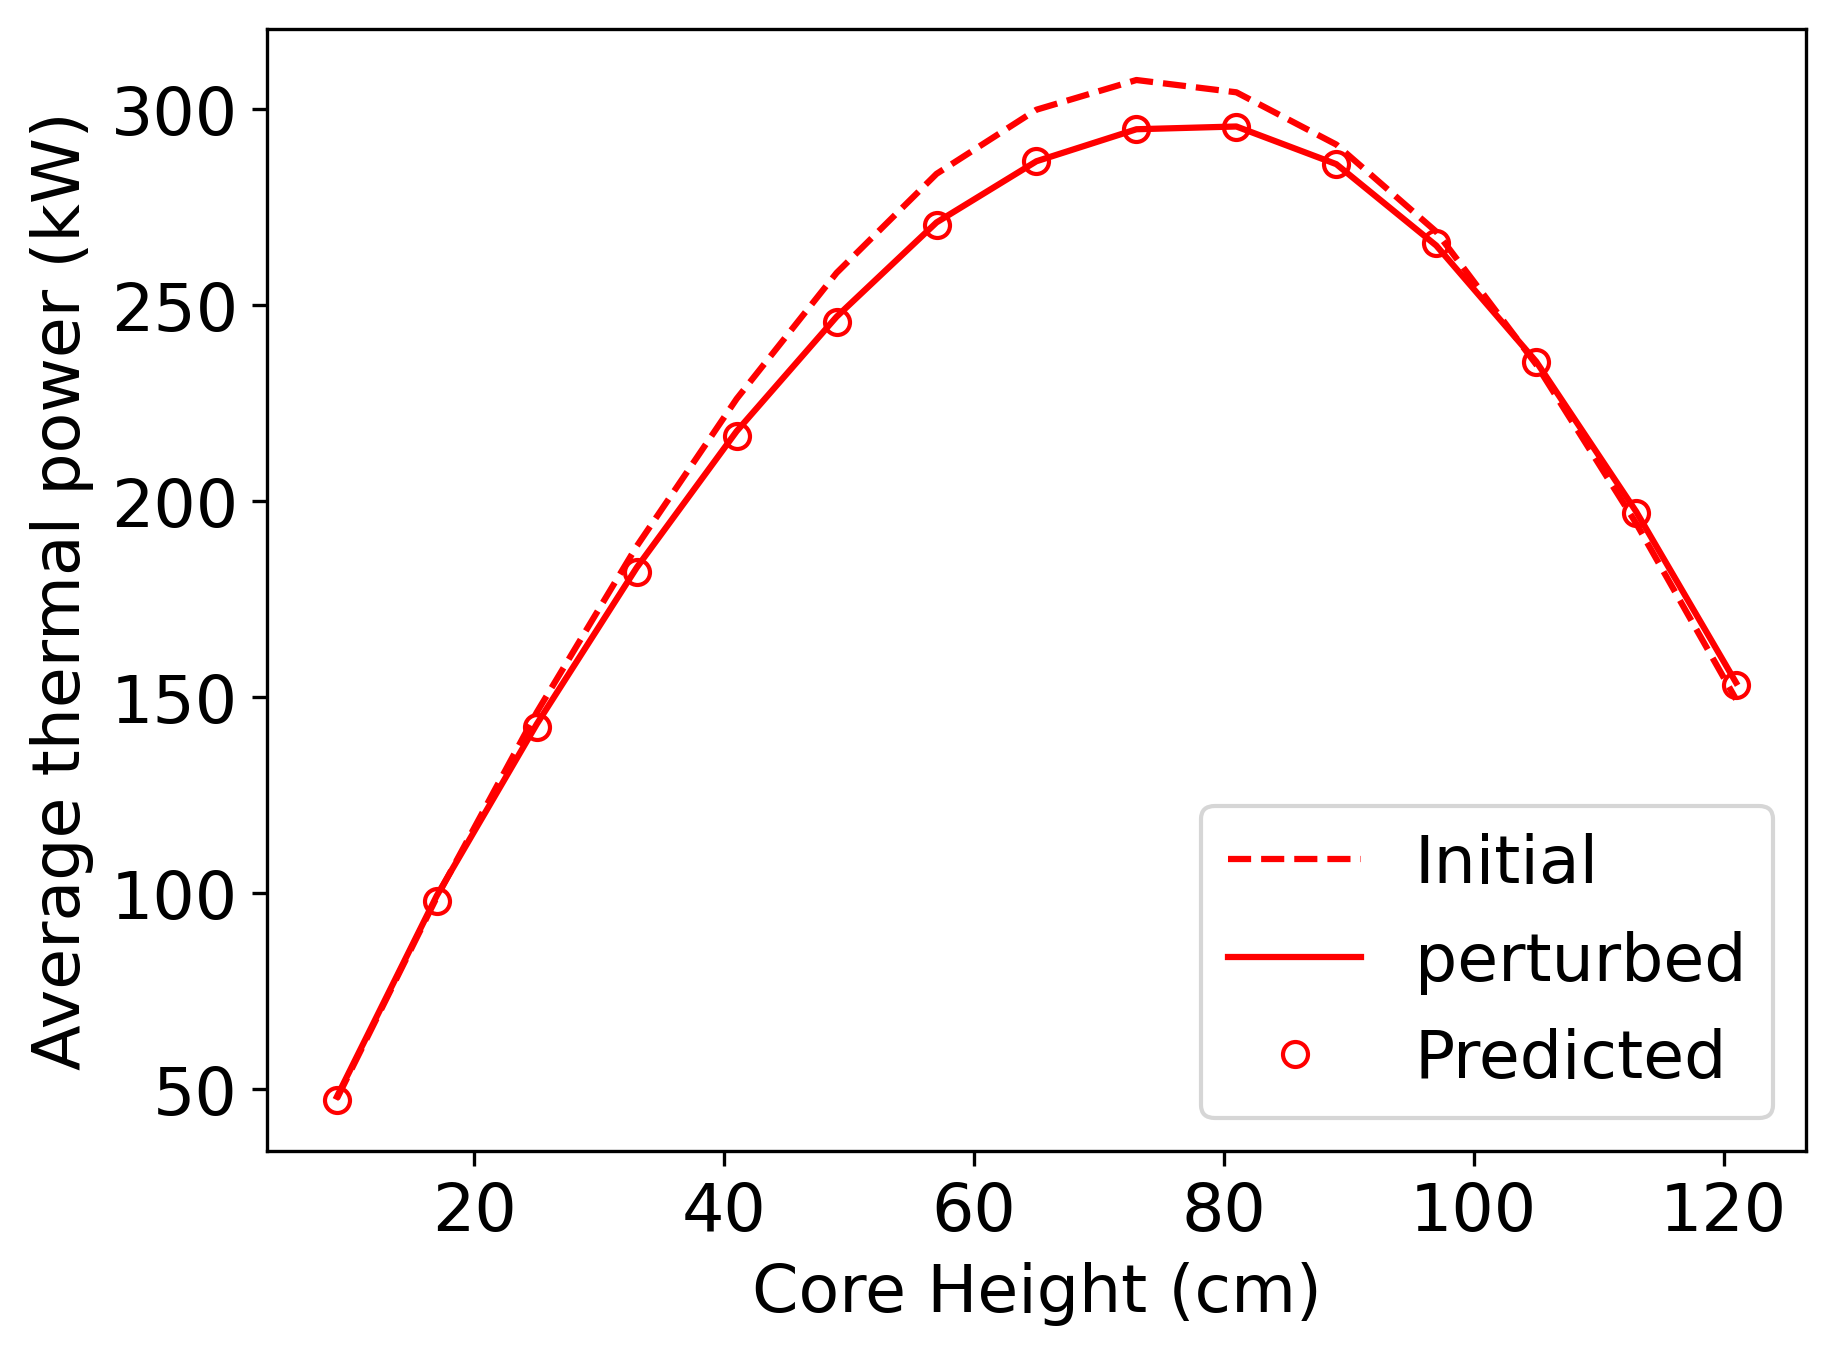

In [72]:
plt.plot(zmid[1:-1],pwr0r[6,1:-1]/nhexes[6]*1e-3,'r--')
plt.plot(zmid[1:-1],pwr2r[6,1:-1]/nhexes[6]*1e-3,'r-')
plt.plot(zmid[1:-1],pwr2p[6,1:-1]/nhexes[6]*1e-3,'ro',markerfacecolor="None")
plt.legend(["Initial","perturbed","Predicted"])
plt.ylabel("Average thermal power (kW)")
plt.xlabel("Core Height (cm)")
plt.tight_layout()
if predicted_xs and adf_type=="initial":
    plt.savefig(r"D:\OneDrive - Georgia Institute of Technology\Desktop\ETF_Journal\NTP_results\power_ring1_{}to{}.png".format(it0,it2))

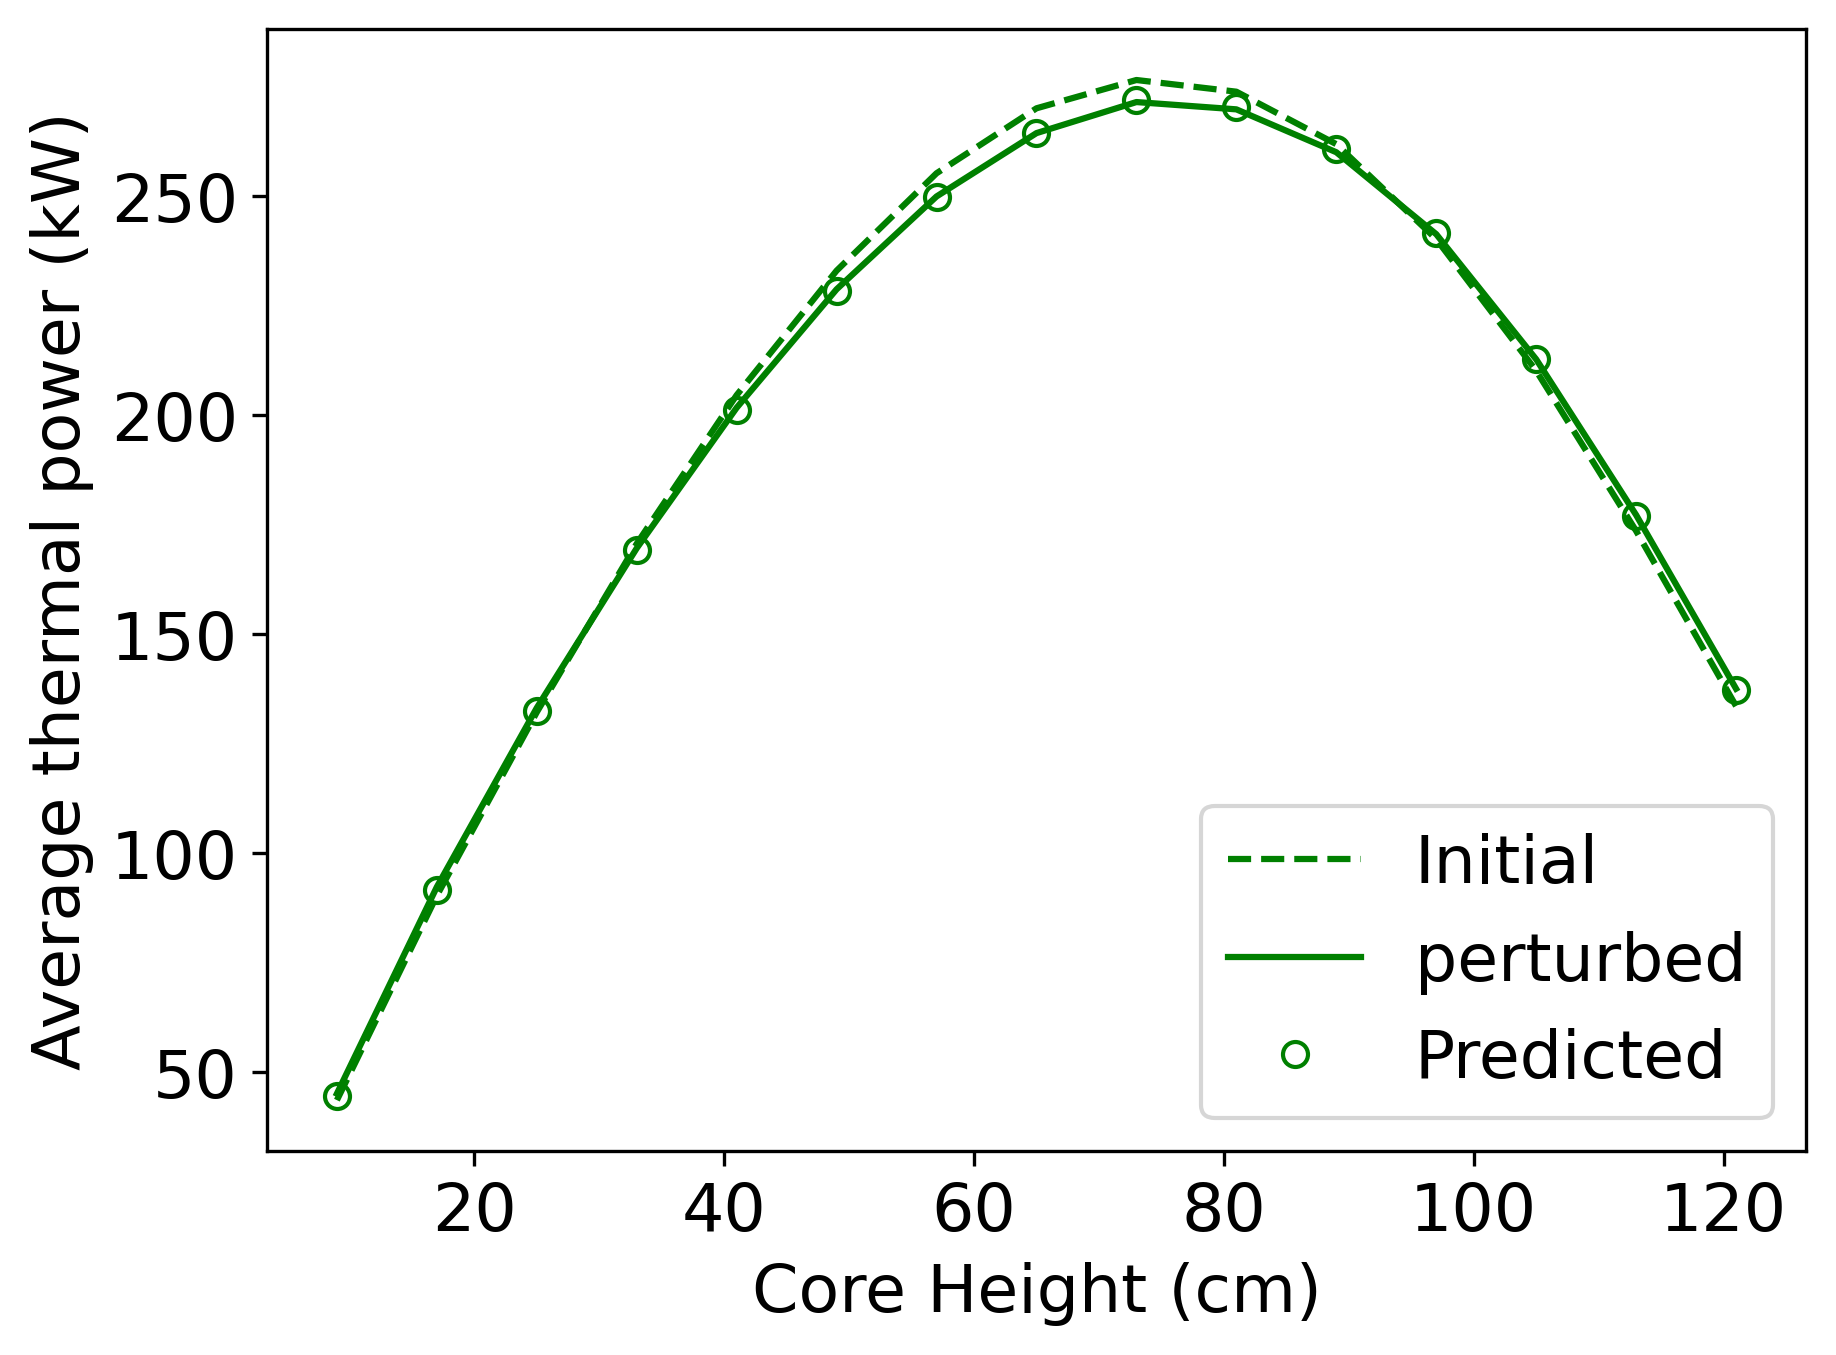

In [73]:
plt.plot(zmid[1:-1],pwr0r[3,1:-1]/nhexes[3]*1e-3,'g--')
plt.plot(zmid[1:-1],pwr2r[3,1:-1]/nhexes[3]*1e-3,'g-')
plt.plot(zmid[1:-1],pwr2p[3,1:-1]/nhexes[3]*1e-3,'go',markerfacecolor="None")
plt.legend(["Initial","perturbed","Predicted"])
plt.ylabel("Average thermal power (kW)")
plt.xlabel("Core Height (cm)")
plt.tight_layout()
if predicted_xs and adf_type=="initial":
    plt.savefig(r"D:\OneDrive - Georgia Institute of Technology\Desktop\ETF_Journal\NTP_results\power_ring4_{}to{}.png".format(it0,it2))

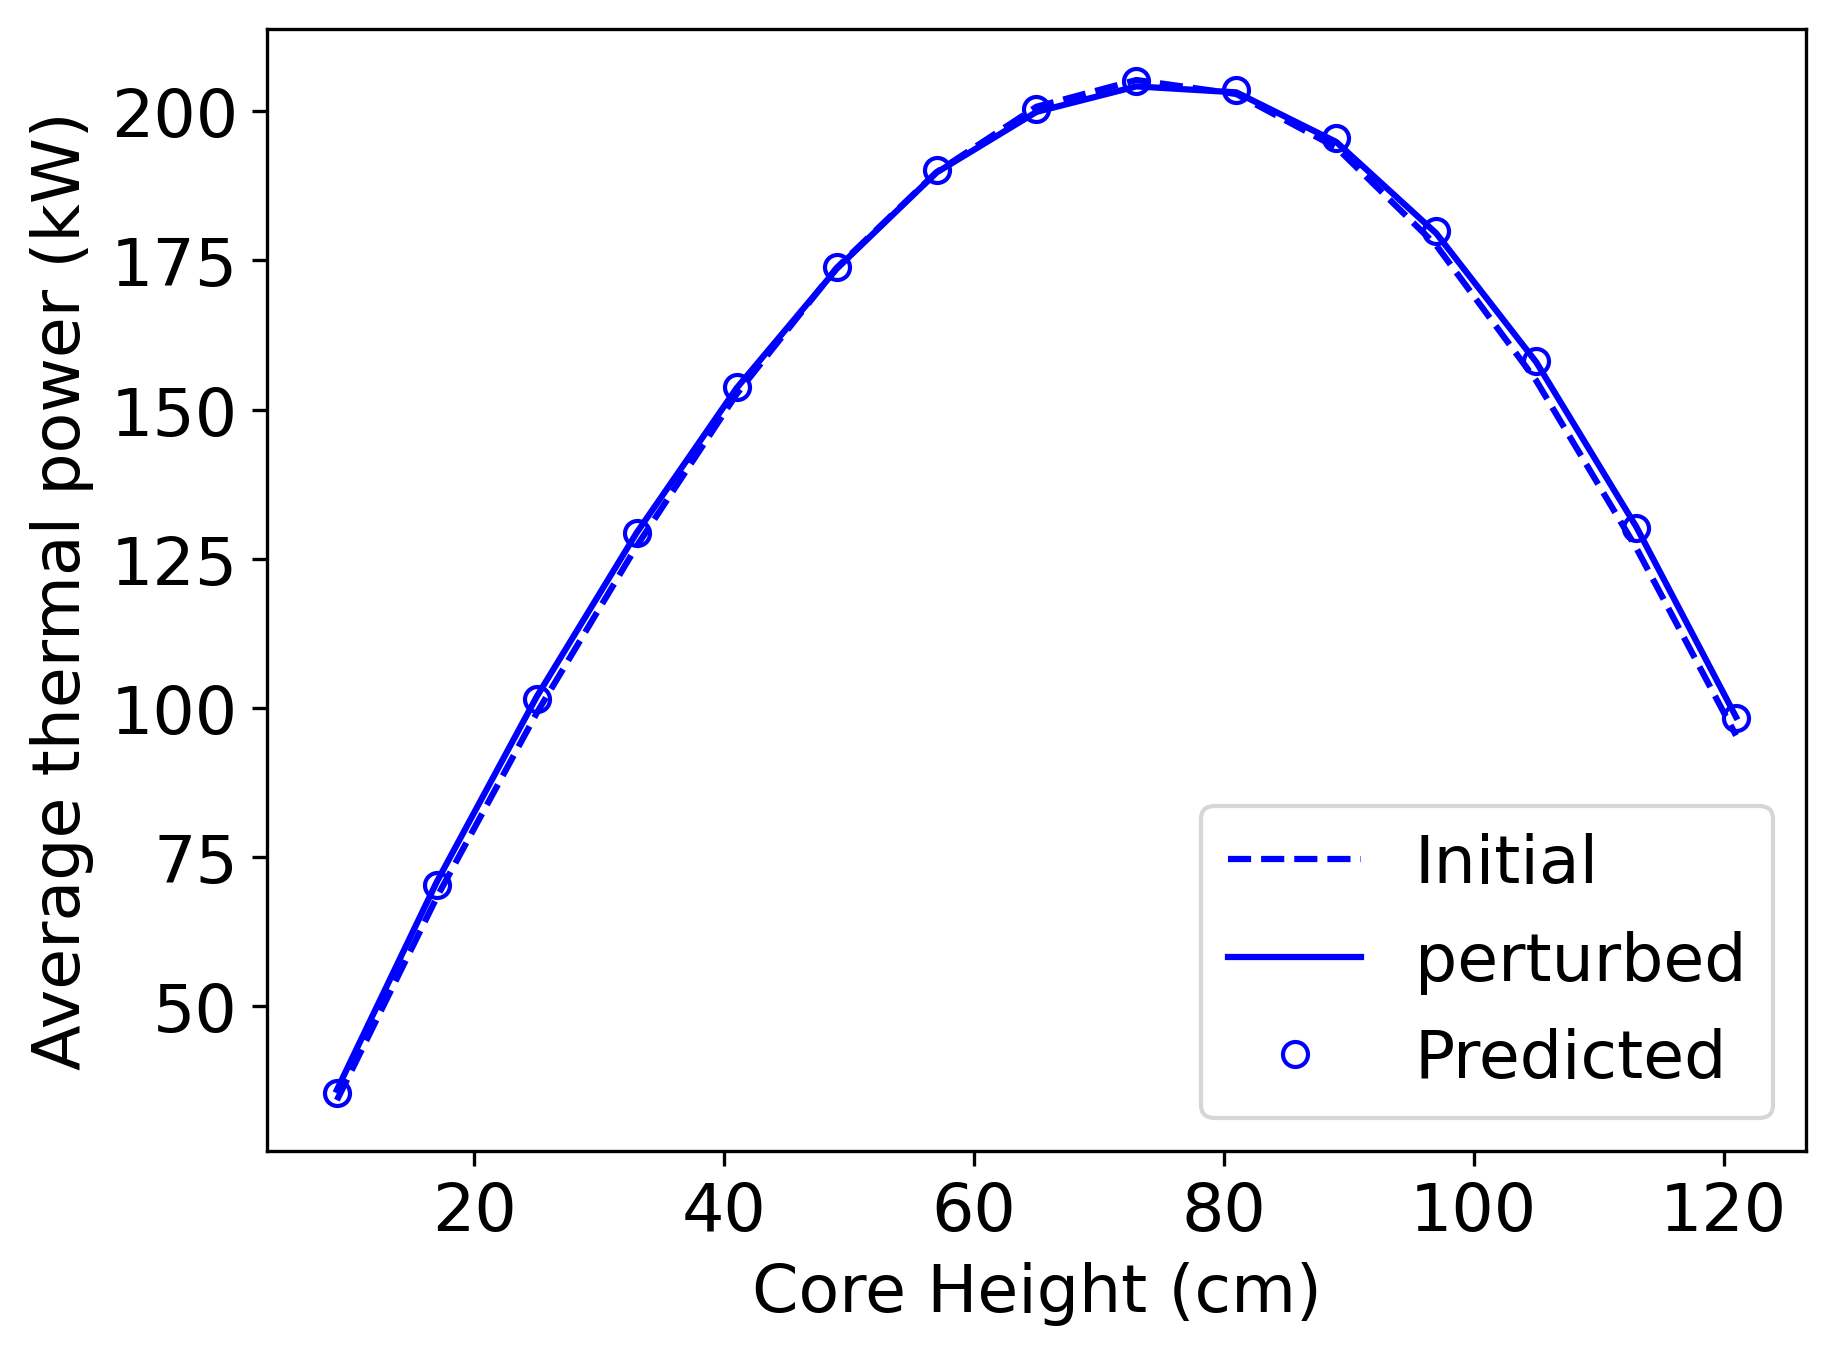

In [74]:
plt.plot(zmid[1:-1],pwr0r[0,1:-1]/nhexes[0]*1e-3,'b--')
plt.plot(zmid[1:-1],pwr2r[0,1:-1]/nhexes[0]*1e-3,'b-')
plt.plot(zmid[1:-1],pwr2p[0,1:-1]/nhexes[0]*1e-3,'bo',markerfacecolor="None")
plt.legend(["Initial","perturbed","Predicted"])
plt.ylabel("Average thermal power (kW)")
plt.xlabel("Core Height (cm)")
plt.tight_layout()
if predicted_xs and adf_type=="initial":
    plt.savefig(r"D:\OneDrive - Georgia Institute of Technology\Desktop\ETF_Journal\NTP_results\power_ring7_{}to{}.png".format(it0,it2))

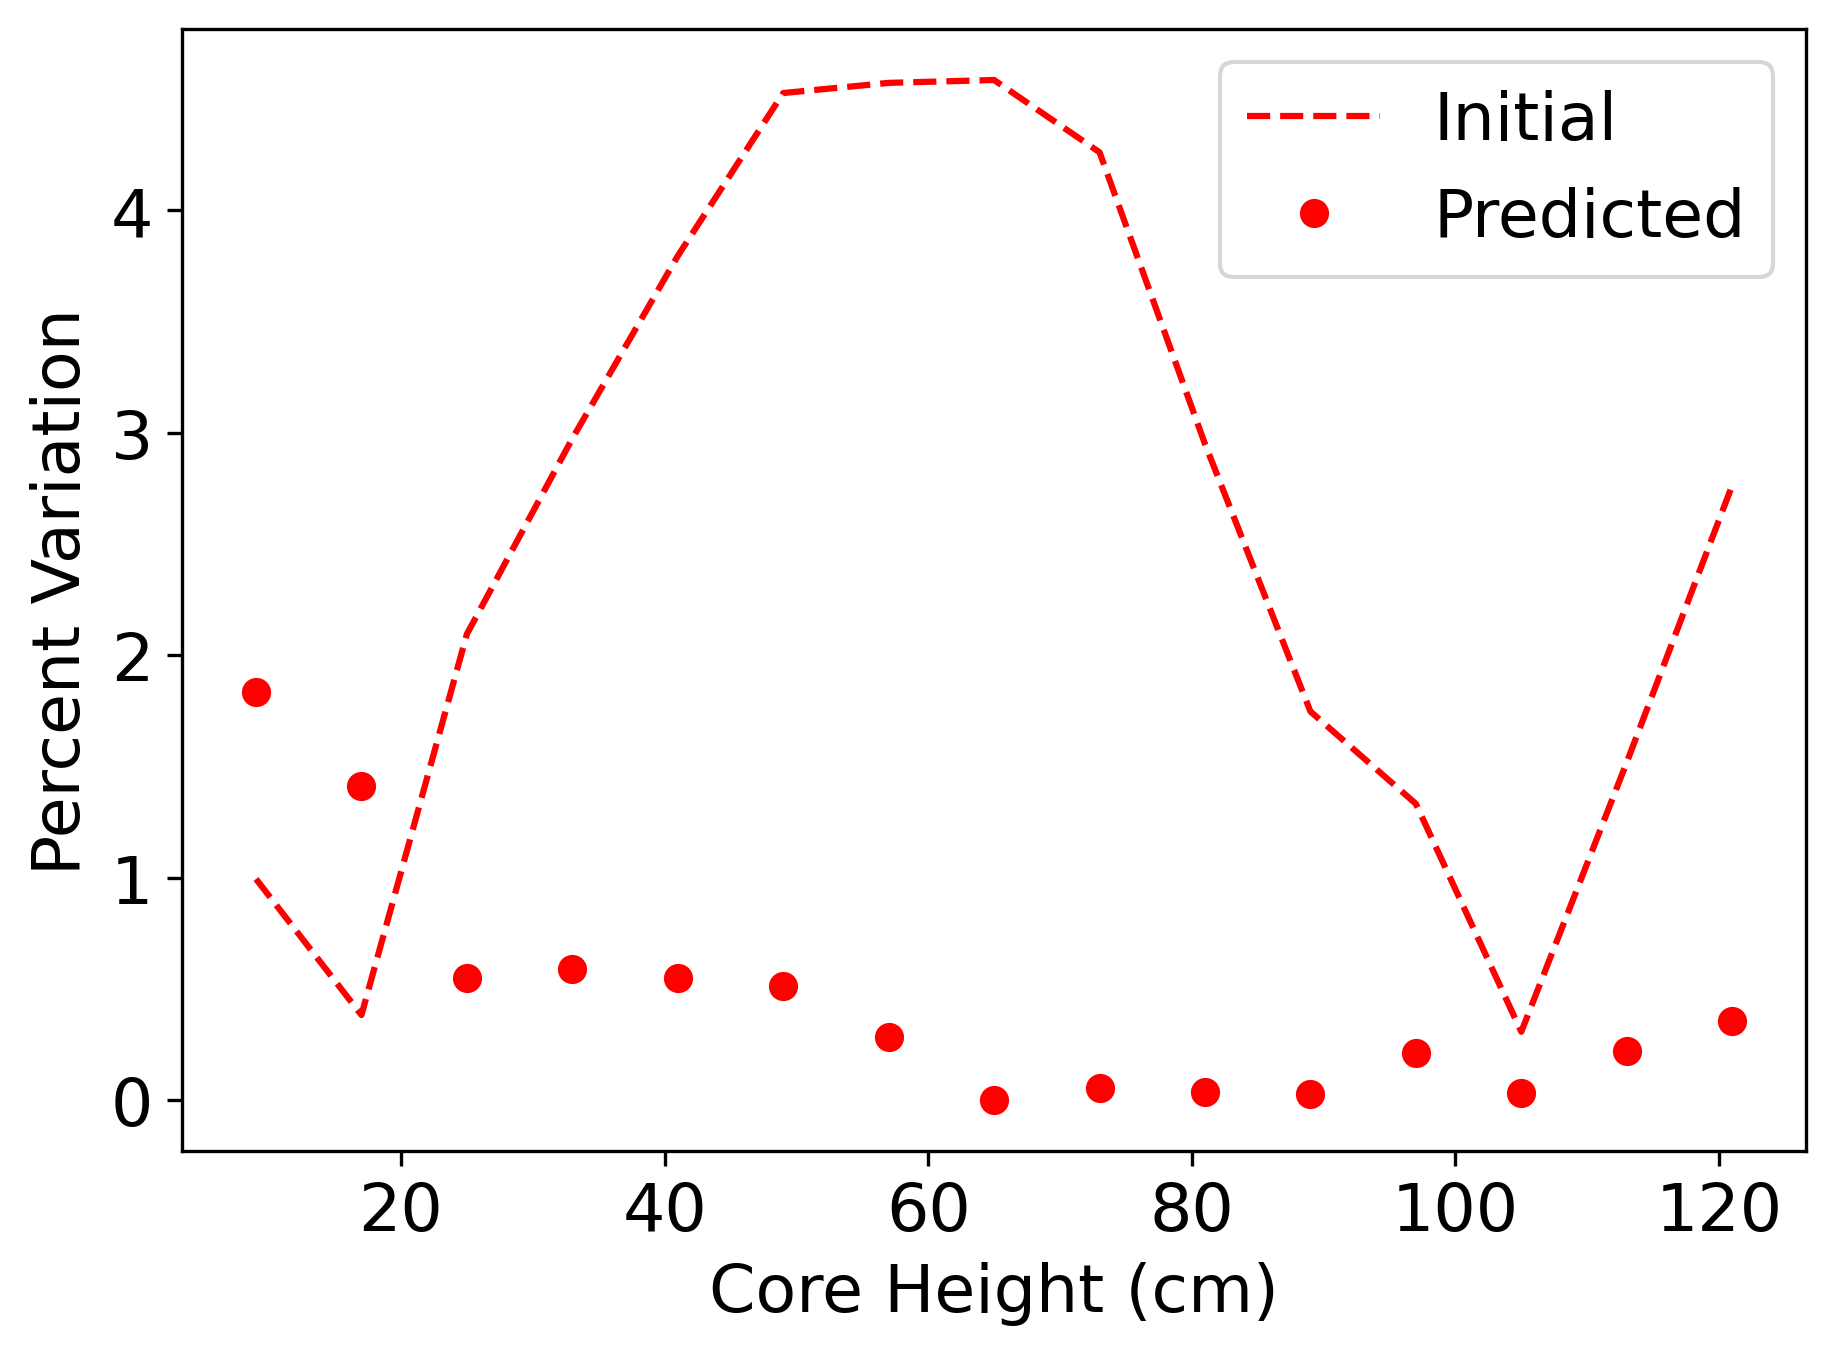

In [75]:
plt.plot(zmid[1:-1],abs(pwr0r[6,1:-1]/pwr2r[6,1:-1]-1)*100,'r--')
plt.plot(zmid[1:-1],abs(pwr2p[6,1:-1]/pwr2r[6,1:-1]-1)*100,'ro')
plt.legend(["Initial", "Predicted"])
plt.ylabel("Percent Variation")
plt.xlabel("Core Height (cm)")
plt.tight_layout()
plt.savefig(r"D:\OneDrive - Georgia Institute of Technology\Desktop\ETF_Journal\NTP_results\error_ring1_{}to{}.png".format(it0,it2))

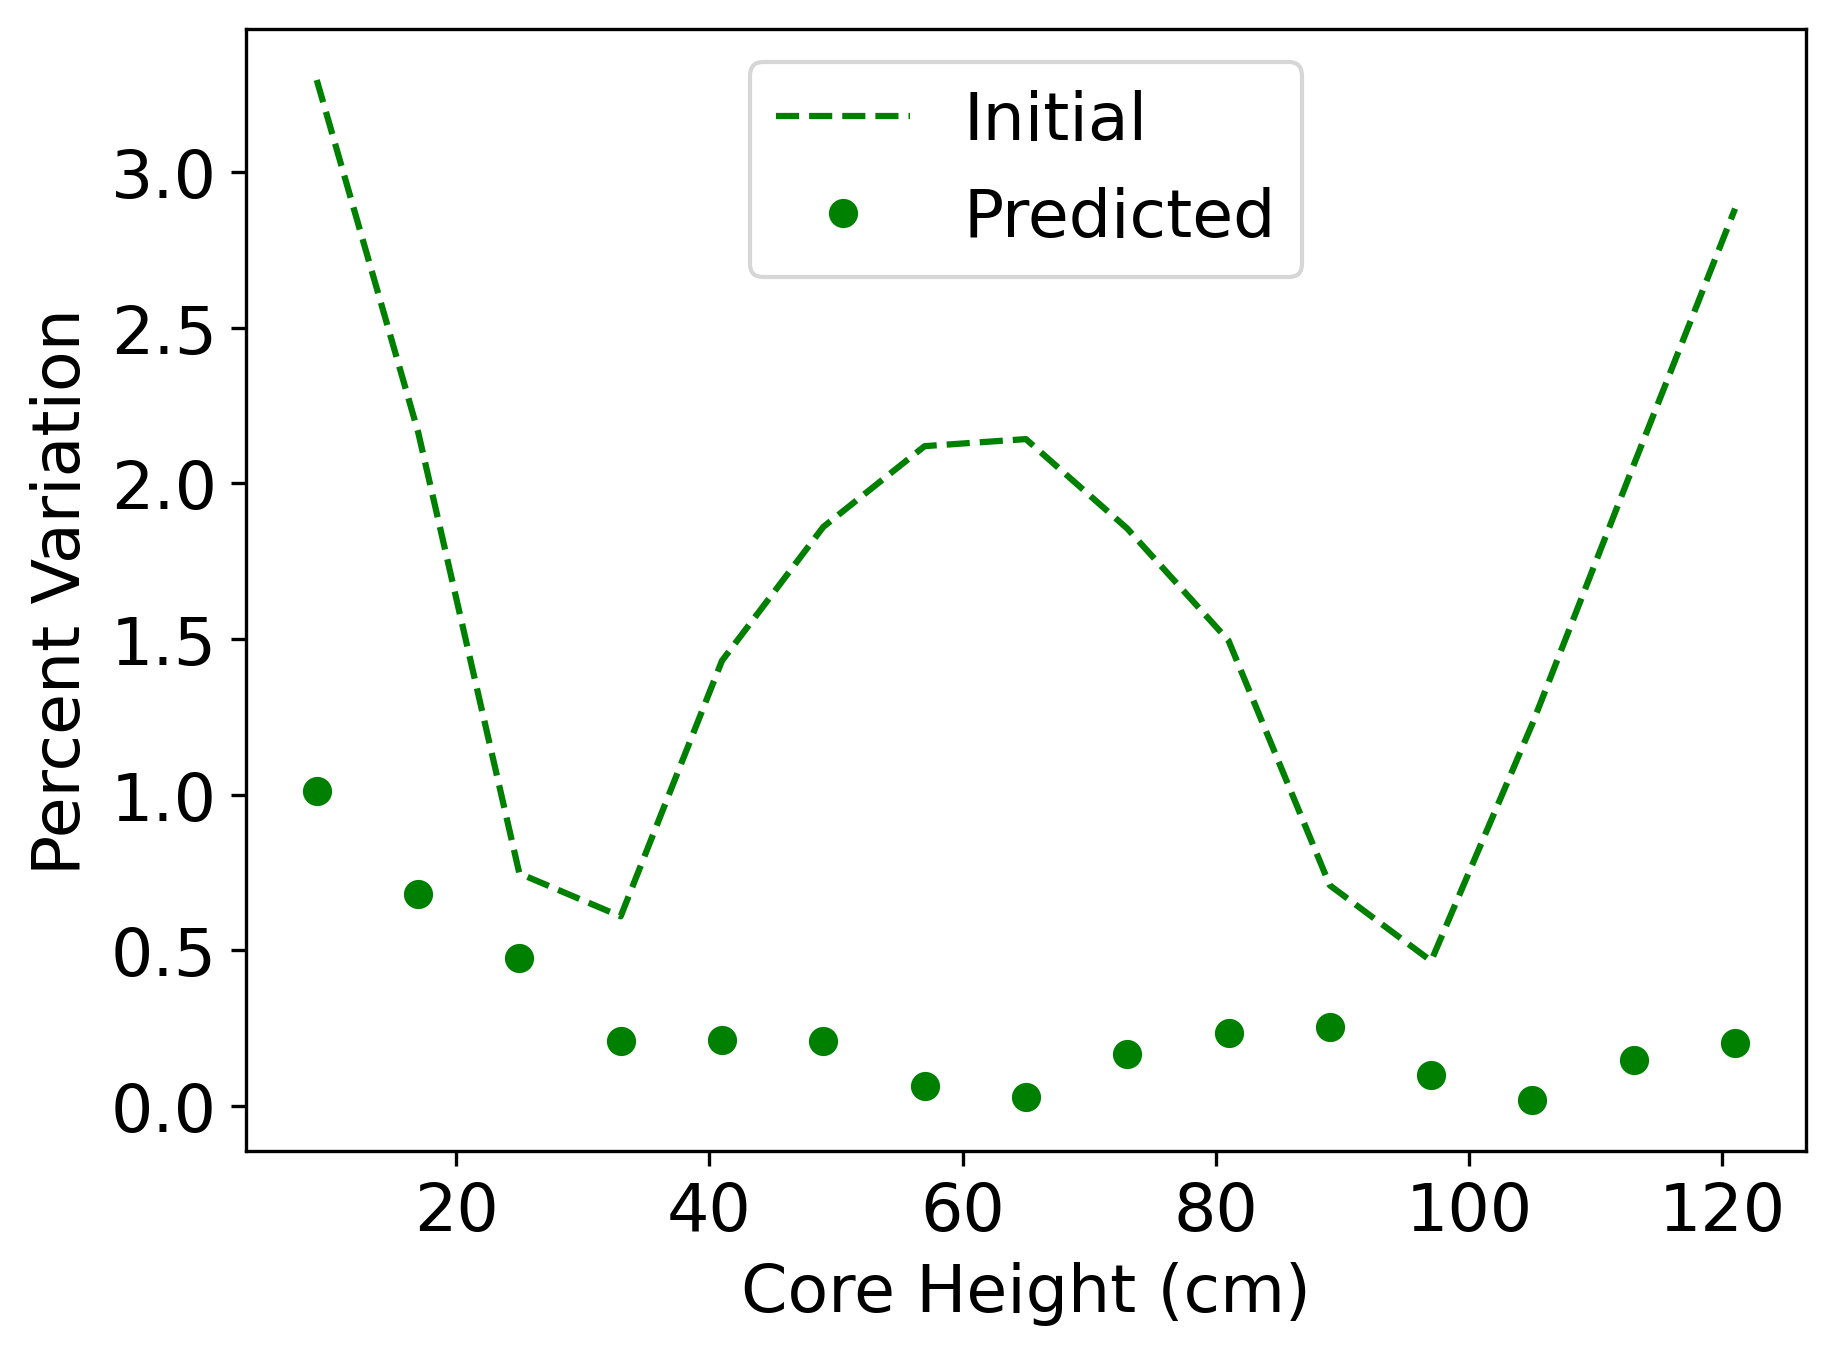

In [76]:
plt.plot(zmid[1:-1],abs(pwr0r[3,1:-1]/pwr2r[3,1:-1]-1)*100,'g--')
plt.plot(zmid[1:-1],abs(pwr2p[3,1:-1]/pwr2r[3,1:-1]-1)*100,'go')
plt.legend(["Initial", "Predicted"])
plt.ylabel("Percent Variation")
plt.xlabel("Core Height (cm)")
plt.tight_layout()
plt.savefig(r"D:\OneDrive - Georgia Institute of Technology\Desktop\ETF_Journal\NTP_results\error_ring4_{}to{}.png".format(it0,it2))

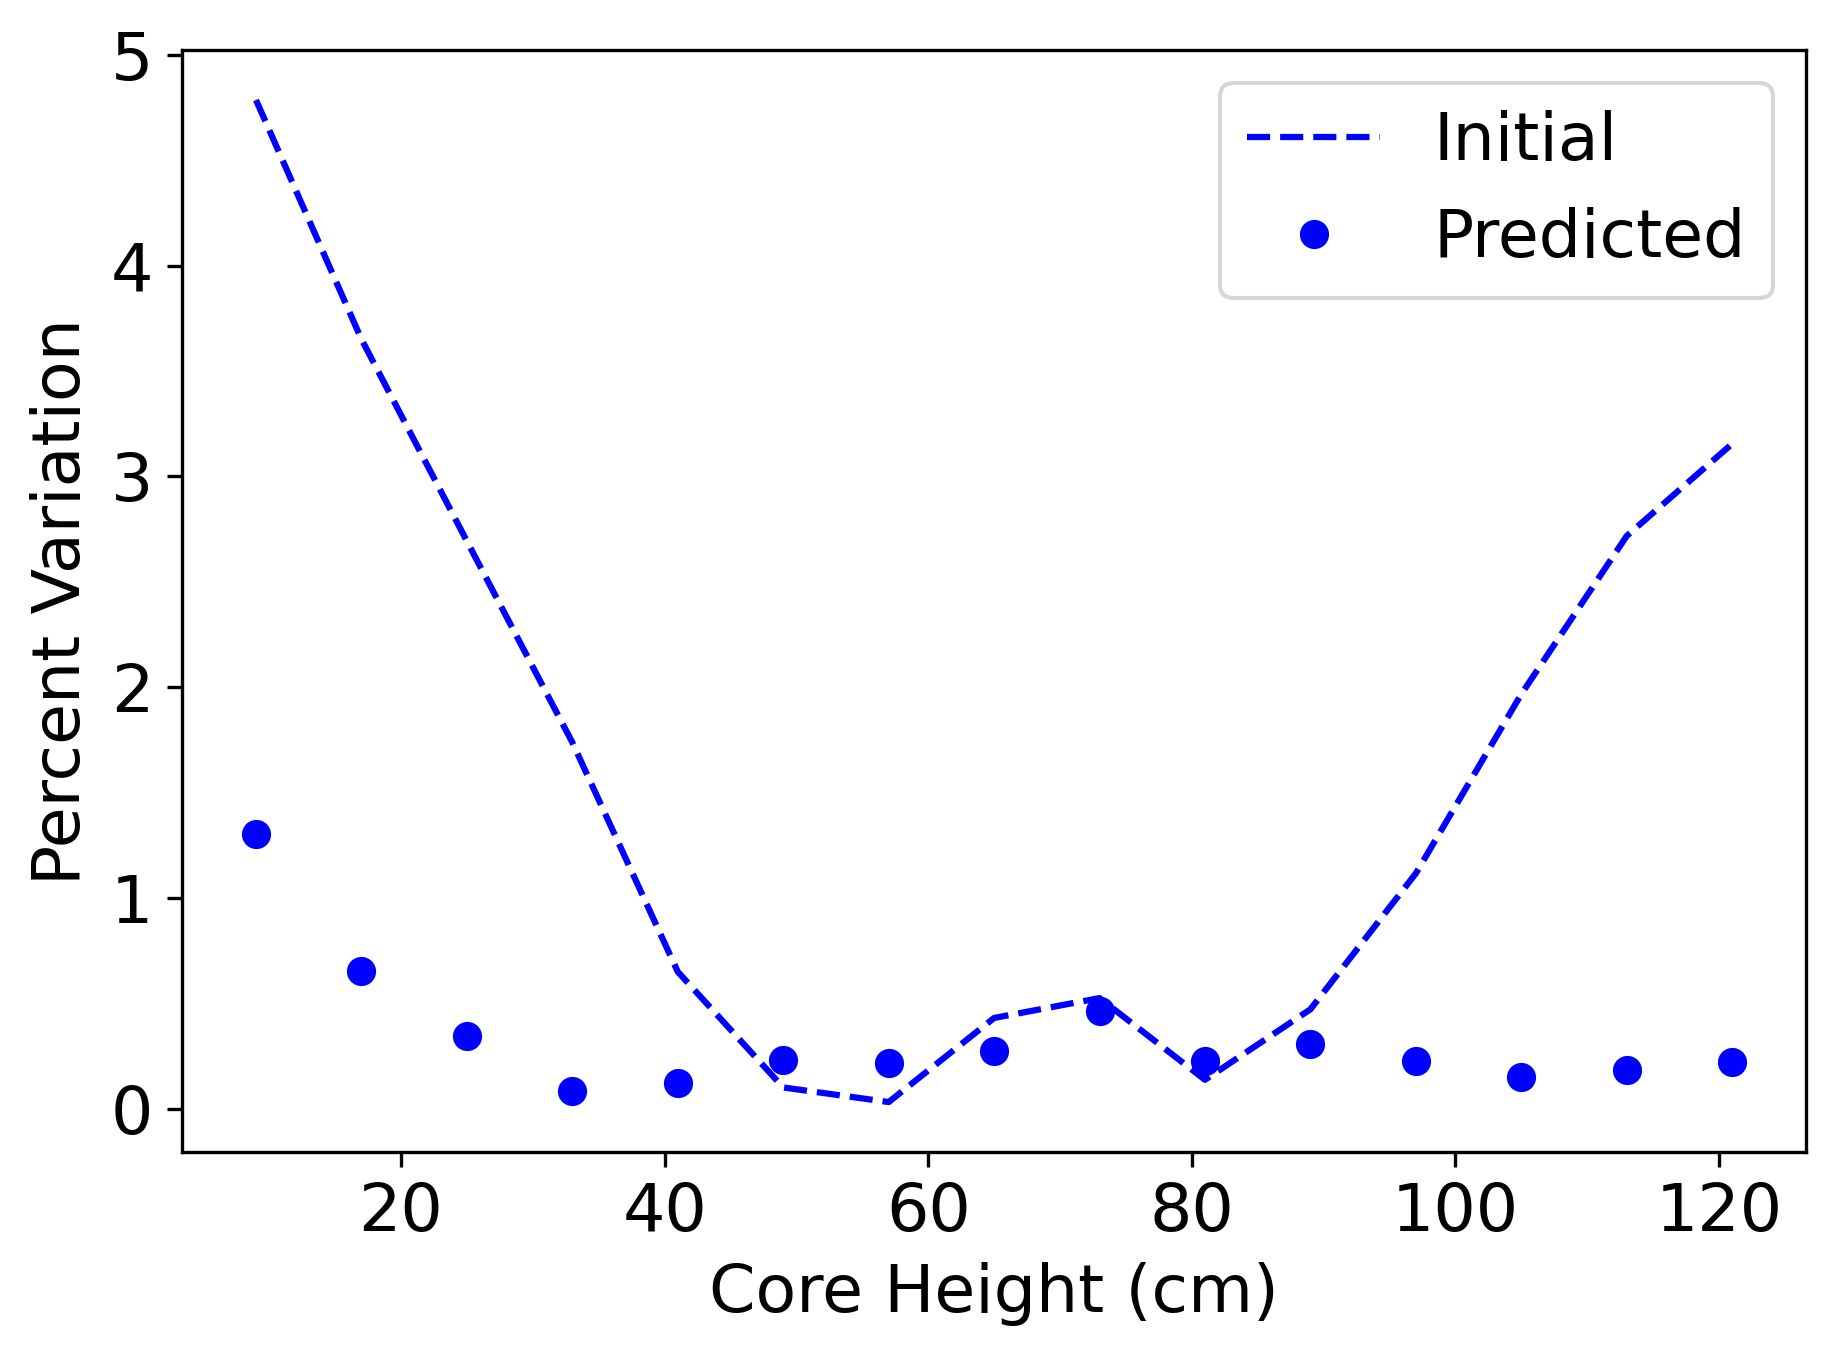

In [77]:
plt.plot(zmid[1:-1],abs(pwr0r[0,1:-1]/pwr2r[0,1:-1]-1)*100,'b--')
plt.plot(zmid[1:-1],abs(pwr2p[0,1:-1]/pwr2r[0,1:-1]-1)*100,'bo')
plt.legend(["Initial", "Predicted"])
plt.ylabel("Percent Variation")
plt.xlabel("Core Height (cm)")
plt.tight_layout()
plt.savefig(r"D:\OneDrive - Georgia Institute of Technology\Desktop\ETF_Journal\NTP_results\error_ring7_{}to{}.png".format(it0,it2))